In [1]:
'''
General comments:

Same as "atlasInverseTransform_connectivityMatrix_secondAcquisition_v0" but creating and applying T_correctedEPI2inputEPI.
'''

import nibabel as nib
import numpy as np
from joblib import Parallel, delayed
import multiprocessing

import os
import subprocess



import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import scipy.io as scio

import numpy as np
import os
from glob import glob
import nibabel as nb
import nibabel
#from pylab import *
import scipy.signal
from nilearn.masking import apply_mask
from nilearn.masking import unmask
import nilearn.signal
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"   # to hide os warning about h5py
import numpy as np
from glob import glob
import nibabel as nib
import re
from sklearn.decomposition import PCA
import itertools
import nilearn.masking
from nilearn import image
import scipy.ndimage
from nilearn.masking import apply_mask, unmask
import nipype.interfaces.fsl as fsl
import pickle
from joblib import Parallel, delayed
import nipype.pipeline.engine as pe          # pypeline engine 
import nipype.interfaces.spm as spm          # spm
#import nipype.interfaces.matlab as mlab
#mlab.MatlabCommand.set_default_paths('/home/miv/bhanot/soft/Ants/bin') # Set paths for Ants
#mlab.MatlabCommand.set_default_paths('/home/miv/bhanot/spm12')  # Set paths for spm
from nilearn.masking import compute_multi_epi_mask, compute_epi_mask, new_img_like
import scipy
import nipype.interfaces.ants as ants
#import skimage.exposure as ex
from nipype.interfaces.nipy import ComputeMask

import sys
sys.path.append('libs/')
#from time_series import *

from scipy.signal import butter, lfilter

import datetime


def create_path(path_to_create):
    if not os.path.exists(path_to_create):
            os.makedirs(path_to_create)
            
def least_sqr(Y, A, mu_tikhonov):
    At = np.transpose(A)
    AA =  np.matmul( A, At) + mu_tikhonov * np.eye( A.shape[0] )
    tmp1 = np.linalg.inv( AA )
    tmp = np.matmul(Y,At)
    U_new = np.matmul(tmp,tmp1)
    return U_new



def BuildImagePath(pathDatasink,shorterPath,intFolder,printResults):
    print('\nCreating array of image paths...')    
    os.chdir(pathDatasink)

    arrayPath = !{'ls'}
    print('Array size: %d items.' % len(arrayPath))
    #print(array)

    arrayPathImage = arrayPath
    for index in range (len(arrayPath)):

        #print(index)
        #print(array[0])

        cmd = 'ls ' + arrayPath[index] + intFolder
        image = !{cmd}
        #print(image)


        arrayPathImage[index] = pathDatasink + '/' + arrayPathImage[index] + intFolder + '/' + image[0]
        
        if shorterPath:
            arrayPathImage[index] = pathDatasink + '/' + image[0]
        
        if printResults:
            print(arrayPathImage[index])

    if printResults:
        print(arrayPathImage)
    
    print('Array with paths made!!!\n\n')    
    
    return arrayPathImage


def PrintArray(arrayPrint):
    print('\nPrinting array...')
    print('Array length: %d' % (len(arrayPrint)))
    for index in range (len(arrayPrint)):
        print(arrayPrint[index])
    print('Array printing done!!!\n')
    
    
def SortArrayByRefArray(arrayUnsorted, arrayRef, printResults):
    arraySorted = [None]*len(arrayRef)

    for index in range (len(arrayRef)):
        indexMatch = [i for i, s in enumerate(arrayUnsorted) if arrayRef[index] in s]
        #print(indexMatch)

        if indexMatch==[]:
            print('\nAttention: Subject %s was not found!!!\n' % arrayRef[index])
            print('\nSetting path for the subject %s as None!!!\n' % arrayRef[index])                    
        
        elif (len(indexMatch) > 1):
            print('\nProblem of matching!!! Multiple indexes found!!!\n')
            break

        else:
            if printResults:
                print(index)
                print(indexMatch)
            arraySorted[index] = arrayUnsorted[indexMatch[0]]

    if printResults:    
        print(arraySorted)
    
    return arraySorted


def TapTerminalCommand(commonCmd, arraySubj, arrayPathInput, arrayPathRef, arrayPathTrans, sufix, transFormat, inverseTrans, posEraseEnd, printCmd, executeCmd):
    arrayPathOutput = [None]*len(arraySubj)
    cmdArray = [None]*len(arraySubj)
    
    
    for indexSubject in range (len(arraySubj)):
        pathOutputImage = arrayPathInput[indexSubject][:-posEraseEnd] + sufix + '_'+ arraySubj[indexSubject] + '.nii'
        if transFormat == '.nii':
            cmd = commonCmd + ' --input ' + arrayPathInput[indexSubject] + ' --output ' + pathOutputImage + ' --reference-image ' + arrayPathRef[indexSubject] + ' --transform ' + arrayPathTrans[indexSubject]
        
        elif transFormat == '.mat':
            cmd = commonCmd + ' --input ' + arrayPathInput[indexSubject] + ' --output ' + pathOutputImage + ' --reference-image ' + arrayPathRef[indexSubject] + ' --transform ' + '[' +  arrayPathTrans[indexSubject] + ',' + str(inverseTrans) + ']'
        
        arrayPathOutput[indexSubject] = pathOutputImage
        cmdArray[indexSubject] = cmd
        
        if printCmd:
            print(cmd)
            
        if executeCmd:
            !{cmd}
    return arrayPathOutput, cmdArray


def TapFSLTerminalCommand(commonCmd, arraySubj, arrayPathInput, mathOper, suffix, pathOutput, printCmd, executeCmd):
    arrayPathOutput = [None]*len(arraySubj)
    cmdArray = [None]*len(arraySubj)
    
    
    for indexSubject in range (len(arraySubj)):
        
        pathOutputImage = pathOutput + '/' + suffix + '_'+ arraySubj[indexSubject] + '.nii.gz'
        
        cmd = commonCmd + ' ' + arrayPathInput[indexSubject] + ' ' + mathOper + ' ' + pathOutputImage
        
        arrayPathOutput[indexSubject] = pathOutputImage
        cmdArray[indexSubject] = cmd
        
        if printCmd:
            print(cmd)
            
        if executeCmd:
            !{cmd}
    return arrayPathOutput, cmdArray



def TapANTsRegisteringTerminalCommand(commonCmd, arraySubj, arrayPathInputRef, arrayPathInputToBeRegistered, pathOutput, posEraseEnd, printCmd, executeCmd):
    arrayPathOutputImage = [None]*len(arraySubj)
    arrayPathOutputTransfMat = [None]*len(arraySubj)
    arrayPathOutputTransfComposite = [None]*len(arraySubj)
    arrayPathOutputTransfInvComposite = [None]*len(arraySubj)
    cmdArray = [None]*len(arraySubj)
    
    
    for indexSubject in range (len(arraySubj)):
        
        arrayPathInputRefHeadTail = os.path.split(arrayPathInputRef[indexSubject])
        arrayPathInputToBeRegisteredHeadTail = os.path.split(arrayPathInputToBeRegistered[indexSubject])
        
        pathOutputReg = pathOutput + '/' + 'outputANTsReg_' + arraySubj[indexSubject] + '_' + arrayPathInputToBeRegisteredHeadTail[1][:-posEraseEnd] + '_2_' + arrayPathInputRefHeadTail[1][:-posEraseEnd] + '_'
        
        cmd = commonCmd + ' --output [ ' + pathOutputReg + ' , ' + pathOutputReg + 'warpedImage.nii' + ']' + ' --save-state ' + pathOutputReg + 'trans.mat' + ' --transform Affine[ 2.0 ] --metric Mattes[ ' + arrayPathInputRef[indexSubject] + ' , ' + arrayPathInputToBeRegistered[indexSubject] + ', 1, 32, Random, 0.05 ]' + ' --convergence [ 1500x200, 1e-08, 20 ] --smoothing-sigmas 1.0x0.0vox --shrink-factors 2x1 --use-estimate-learning-rate-once 1 --use-histogram-matching 1' + ' --transform SyN[ 0.25, 3.0, 0.0 ] --metric Mattes[ ' + arrayPathInputRef[indexSubject] + ' , ' + arrayPathInputToBeRegistered[indexSubject] + ', 1, 32 ]' + ' --convergence [ 100x50x30, 1e-09, 20 ] --smoothing-sigmas 2.0x1.0x0.0vox --shrink-factors 3x2x1 --use-estimate-learning-rate-once 1 --use-histogram-matching 1 --winsorize-image-intensities [ 0.0, 1.0 ] --write-composite-transform 1'
        
        arrayPathOutputImage[indexSubject] = pathOutputReg + 'warpedImage.nii'
        arrayPathOutputTransfMat[indexSubject] = pathOutputReg + 'trans.mat'
        arrayPathOutputTransfComposite[indexSubject] = pathOutputReg + 'Composite.h5'
        arrayPathOutputTransfInvComposite[indexSubject] = pathOutputReg + 'InverseComposite.h5'
        
        cmdArray[indexSubject] = cmd
        
        if printCmd:
            print(cmd)
            
        if executeCmd:
            !{cmd}
    return arrayPathOutputImage, arrayPathOutputTransfMat, arrayPathOutputTransfComposite, arrayPathOutputTransfInvComposite, cmdArray



def TapCopyTerminalCommand(commonCmd, arraySubj, arrayPathInput, newName, pathOutput, printCmd, executeCmd):
    arrayPathOutput = [None]*len(arraySubj)
    cmdArray = [None]*len(arraySubj)
    
    
    for indexSubject in range (len(arraySubj)):
        
        pathOutputImage = pathOutput + '/' + newName + '_'+ arraySubj[indexSubject] + '.nii.gz'
        
        cmd = commonCmd + ' ' + arrayPathInput[indexSubject] + ' ' + pathOutputImage
        
        arrayPathOutput[indexSubject] = pathOutputImage
        cmdArray[indexSubject] = cmd
        
        if printCmd:
            print(cmd)
            
        if executeCmd:
            !{cmd}
    return arrayPathOutput, cmdArray



def CreateConnectivityMatrix(arrayPathfMRIData, arrayPathRegisteredBrainMask, arrayPathRegisteredAtlas, pathLabels, arraySubj, pathOutput, lowCutArray, highCutArray, fs, freqFilterOrderArray, invProbParArray, normWeight, nLabels,  eraseFirstLabel, extImage, extMatrix, folderName, printResults, figSize, saveFiles, saveArrays):

    
    now = datetime.datetime.now()
    
    
    for lowCut in lowCutArray:
        for highCut in highCutArray:
            for freqFilterOrder in freqFilterOrderArray:
                for invProbPar in invProbParArray:
        
                    print('\n\nCreating connectivity matrix ...\n')

                    pathOutputGlobal = pathOutput + '/' + now.strftime("%Y%m%d_%H%M%S_") + folderName + '_nLabels-' + str(nLabels) +'_butterworthFilter' + '_lowCut-' + str(lowCut) + '_highCut-' + str(highCut) + '_fs-' + str(fs) + '_filterOrder-' + str(freqFilterOrder) + '_invProblParam-' + str('%.1e' % invProbPar) +'_weightNormOption-' + str(normWeight) + '_eraseFirstLabelOption-' + str(eraseFirstLabel)
                
                    print('Main folder: %s' % pathOutputGlobal)
                    !{'mkdir ' + pathOutputGlobal}
                    
    
                    
                    for index in range (len(arrayPathfMRIData)):


                        fmridata = nib.load(arrayPathfMRIData[index])
                        brainMask = nib.load(arrayPathRegisteredBrainMask[index])
                        anno_masks = nib.load(arrayPathRegisteredAtlas[index])
                        labelscsv = pd.read_csv(pathLabels, sep='\t', header=None) 


                        brain_mask = np.where(brainMask.get_fdata()>0.05,1,0)
                        #ndimage.binary_fill_holes(brain_mask).astype(int)

                        brain_mask = nib.Nifti1Image(brain_mask, brainMask.affine)

                        pathOutputSubject = pathOutputGlobal + '/connectivityMatrix_' + arraySubj[index] + '_' + nLabels + 'Labels'
                        print(pathOutputSubject)
                        #figSize = 50

                        if printResults:
                            print("\nOriginal labels:")
                            print(labelscsv)

                        if eraseFirstLabel:
                            labelscsv = labelscsv[1:]

                            if printResults:
                                print("\nRegions without first one (root):")
                                print(labelscsv)


                        print('\nMasking atlas...')
                        anno4d = apply_mask(anno_masks, brain_mask)                
                        print('Done!!!')

                        if (not(nLabels=='all')):            
                            nRegions = anno4d.shape
                            print(nRegions)
                            print(nRegions[0])
                            print(int(int(nLabels)))
                            print(int(nRegions[0]/2))
                            print(int(nRegions[0]/2+int(nLabels)))

                            print(anno4d.shape)
                            print(anno4d[0:int(nLabels),:].shape)
                            print(anno4d[int(nRegions[0]/2):int(nRegions[0]/2+int(nLabels)),:].shape)
                            anno4d = np.concatenate((anno4d[0:int(nLabels),:],anno4d[int(nRegions[0]/2):int(nRegions[0]/2+int(nLabels)),:])) 
                            print(anno4d.shape)

                            labelscsv = pd.concat((labelscsv[0:int(nLabels)],labelscsv[int(nRegions[0]/2):int(nRegions[0]/2+int(nLabels))])) 

                            #figSize = 15

                            if printResults:
                                print("\nReduced labels:")
                                print(labelscsv)                


                        print('\nMasking fMRI data...')
                        anno4d_bin = np.where(anno4d>0.05,1,0)
                        fmridata_matrix = apply_mask(fmridata, brain_mask)
                        print(anno4d_bin.shape)
                        print('Done!!!')


                        A_orig = np.copy(anno4d_bin)
                        Yinit = np.copy(fmridata_matrix)
                        print(Yinit.shape)
                        
                        if saveArrays:
                            np.save((pathOutputGlobal + '/Yraw_' + arraySubj[index] + '_' + nLabels + 'Labels'), Yinit)
                            np.save((pathOutputGlobal + '/Araw_' + arraySubj[index] + '_' + nLabels + 'Labels'), A_orig)

                        print('\n Analyse of regions per voxel:')
                        print('Sum of Anit') 
                        print(np.sum(A_orig,0))
                        print('Max of Anit') 
                        print(np.max((np.sum(A_orig,0))))

                        if normWeight:
                            print('\nApplying normalization...')
                            Ainit = A_orig/(np.sum(A_orig, 0) + 1e-30)
                            print('Shape Anit')
                            print(Ainit.shape)
                            pathOutputSubject = pathOutputSubject + '_weightNorm'
                            print('Done!!!')

                        else:
                            Ainit = A_orig
                            print('Shape Anit')            
                            print(Ainit.shape)
                            pathOutputSubject = pathOutputSubject + '_noWeightNorm'


                        print('\nApplying Butterworth filter ..')        
                        Y = Yinit[10:,:]
                        Y_orig_augmented = np.zeros((Y.shape[0]+200, Y.shape[1]))
                        Y_orig_augmented[:200,:] = np.flipud(Y[:200,:])
                        #Y_orig_augmented[200:,:] = Y_orig_augmented
                        Y_orig_augmented[200:,:] = Y
                        Y_orig_augmented_bp = apply_bandpass(Y_orig_augmented, lowCut, highCut, fs, order = freqFilterOrder)
                        Y_orig_bp = Y_orig_augmented_bp[200:,:]                      
                        
                        print('Done!!!')

                        print('\nCalculating matrix...')
                        U = least_sqr(Y_orig_bp, Ainit, invProbPar)
                        #U = mean(Yinit, Ainit, invProbPar)
                        
                        if saveArrays:
                            np.save((pathOutputGlobal + '/Yfiltered_' + arraySubj[index] + '_' + nLabels + 'Labels'), Y_orig_bp)
                            np.save((pathOutputGlobal + '/Anormalized_' + arraySubj[index] + '_' + nLabels + 'Labels'), Ainit)

                        cormat = np.corrcoef(U.T)
                        # labelscsv = pd.read_csv('/media/argheesh/DATAPART1/TempArgheesh/2021.12.31_DataFromHome/2021.12.29_Test_rs-fMRI_Mouse/Atlas-template/annoVolume+2000_rsfMRI.nii.csv', sep='\t', header=None)
                        col_one_list = labelscsv[0].tolist()
                        col_two_list = labelscsv[1].tolist()
                        print('Done!!!')

                        if printResults:
                            imageSize = len(labelscsv)
                            %matplotlib inline
                            plt.figure(figsize = (figSize,figSize))
                            plt.imshow(cormat, vmin = -1, vmax = 1, cmap = 'bwr')
                            plt.xticks(np.arange(imageSize),col_two_list, rotation = 90)
                            plt.yticks(np.arange(imageSize),col_two_list)
                            plt.colorbar()            

                            if saveFiles:
                                print('Saving image...')
                                plt.savefig(pathOutputSubject + extImage)
                                print('Done!!!')
                            plt.show()


                        correlation_dic = {"cormat": cormat}

                        if saveFiles:
                            print('Saving matrix...')
                            scio.savemat(pathOutputSubject + extMatrix,correlation_dic)
                            print('Done!!!')

                        print('Connectivity matrix of subject %s made!!!' % arraySubj[index])
                        



def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def apply_bandpass(detrended_fmri, lowcut, highcut, fs, order ):
    bandpassed_fmri = np.zeros_like(detrended_fmri)
    for i in range(detrended_fmri.shape[1]):
        bandpassed_fmri[:,i] = butter_bandpass_filter(detrended_fmri[:,i], lowcut, highcut, fs, order) ## CHECK ORDER
    return bandpassed_fmri

/home/alvesrod/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


230620-02:40:01,755 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.7.0


In [1]:
print("Start")
img = nib.load('/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/atlasesTemplates/p56_original_smallRegionsGrouped/p56_smallRegionsGrouped_v5_leftRight.nii')
affine = img.affine
data = img.get_data()
labels = np.unique(data)
number_of_labels = len(labels)
labels = np.unique(data).astype('int16')
#size = data.shape + (10,)   # add dimension for labels
#labels = [int(x) for x in input().split()] # get int input from user
print(labels, len(labels))
data4d = np.zeros((data.shape[0], data.shape[1], data.shape[2], len(labels)-1))
num_cores = 8
for idx, i in enumerate(labels-1):
    if (idx==0):
        continue
    print(i+1,idx)
    data1 = np.copy(data)
    data1[data1!=i+1]=0
    data1[data1==i+1]=1
    data4d[:,:,:,idx-1]=data1
    data4d = data4d.astype(np.int16)
    
test_img = nib.Nifti1Image(data4d, affine)
test_img.set_data_dtype(np.int16)
save_name = '/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/atlasesTemplates/p56_original_smallRegionsGrouped/4dAtlasForConnectivityMatrix/p56_smallRegionsGrouped_v5_leftRight_4D.nii'   
nib.save(test_img, save_name)
print("It worked")


Start


<ipython-input-1-ccdc224a18eb>:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = img.get_data()


[   0    7   19   45  108  165  227  361  379  454  495  555  573  575
  587  593  608  644  717  809  816  822  885  937 1020 1067 1101 1104
 1106 1108 1109 1111 1112 1114 1115 1116 1117 1119 1120 1121 1122 1126
 1127 1129 1130 1132 1135 1137 1139 1140 1141 1142 1145 1156 1159 1172
 1174 1175 1177 1178 1179 1180 1181 1188 1189 1192 1193 1194 1195 1196
 1198 1199 1200 1201 1202 1207 1208 1212 1216 1217 1221 1227 1228 1229
 1230 1231 1240 1242 1243 1245 1246 1247 1251 1252 1254 1255 1259 1260
 1262 1265 1278 1279 1280 1281 1285 1286 1287 1293 1295 1296 1299 1300
 1301 1302 1303 2007 2019 2045 2108 2165 2227 2361 2379 2454 2495 2555
 2573 2575 2587 2593 2608 2644 2717 2809 2816 2822 2885 2937 3020 3067
 3101 3104 3106 3108 3109 3111 3112 3114 3115 3116 3117 3119 3120 3121
 3122 3126 3127 3129 3130 3132 3135 3137 3139 3140 3141 3142 3145 3156
 3159 3172 3174 3175 3177 3178 3179 3180 3181 3188 3189 3192 3193 3194
 3195 3196 3198 3199 3200 3201 3202 3207 3208 3212 3216 3217 3221 3227
 3228 

In [2]:

# ##################################################################################################################
# Main code
# ##################################################################################################################

# ******************************************************************************************************************
# Variables 
# ******************************************************************************************************************

pathMainInputDir = '/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/rabiesPreProcessing/20230310_output_secondAcquisition_groupedProcessing'
pathAtlas4D = '/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/atlasesTemplates/p56_original_smallRegionsGrouped/4dAtlasForConnectivityMatrix/p56_smallRegionsGrouped_v5_leftRight_4D.nii'


pathOutput = '/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing'

arraySubjects = ['F572','F573','F574','F582','F583','F584','F585','F596','F597','F601','F602','F603','F604','M570','M571','M575','M577','M578','M579','M580','M587','M588','M589','M590','M593','M606','M607']


cmd_generalTransAppli = 'antsApplyTransforms --default-value 0 --float 0 --dimensionality 3 -e 3 -v --interpolation Linear'
# ******************************************************************************************************************
# ******************************************************************************************************************
# ******************************************************************************************************************







In [3]:
# ******************************************************************************************************************
# Execution
# ******************************************************************************************************************

os.chdir(pathOutput)

# ==================================================================================================================
# Resample atlas to the resolution of the EPI
# ==================================================================================================================

pathAtlas4D_fileFolder, pathAtlas4D_fileName = os.path.split(pathAtlas4D)
#print(pathAtlas4D_fileFolder)
#print(pathAtlas4D_fileName)

pathOutputResampledAtlas = pathOutput + '/' + pathAtlas4D_fileName[:-4] + '_resampled.nii'

cmd_resampledAtlas = cmd_generalTransAppli + ' -t identity' + \
' --input ' + pathAtlas4D + \
' --output ' +  pathOutputResampledAtlas + \
' --reference-image ' + pathMainInputDir + '/' + 'main_wf/resample_template/resampled_template.nii.gz'
print(cmd_resampledAtlas)


#!{cmd_resampledAtlas}

# ==================================================================================================================
# ==================================================================================================================
# ==================================================================================================================




antsApplyTransforms --default-value 0 --float 0 --dimensionality 3 -e 3 -v --interpolation Linear -t identity --input /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/atlasesTemplates/p56_original_smallRegionsGrouped/4dAtlasForConnectivityMatrix/p56_smallRegionsGrouped_v5_leftRight_4D.nii --output /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/p56_smallRegionsGrouped_v5_leftRight_4D_resampled.nii --reference-image /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/rabiesPreProcessing/20230310_output_secondAcquisition_groupedProcessing/main_wf/resample_template/resampled_template.nii.gz


In [4]:
# ==================================================================================================================
# Apply inverse warp and affine transformation template to common space
# ==================================================================================================================

pathOutputResampledAtlas_tmpl2ComInvWarp = pathOutputResampledAtlas[:-4] + '_template2CommonInverseWarp.nii'

cmd_resampledAtlas_tmpl2ComInvWarp = cmd_generalTransAppli + ' --input ' + pathOutputResampledAtlas + ' --output ' + pathOutputResampledAtlas_tmpl2ComInvWarp + ' --reference-image ' + pathMainInputDir + '/commonspace_datasink/warped_template/secondlevel_template0_output_warped_image.nii.gz' + ' --transform ' + pathMainInputDir + '/transforms_datasink/template_to_common_inverse_warp/secondlevel_template0_output_1InverseWarp.nii.gz'


pathOutputResampledAtlas_tmpl2ComInvWarpAff = pathOutputResampledAtlas_tmpl2ComInvWarp[:-4] + 'Affine.nii'
cmd_resampledAtlas_tmpl2ComInvWarpAff = cmd_generalTransAppli + ' --input ' + pathOutputResampledAtlas_tmpl2ComInvWarp + ' --output ' + pathOutputResampledAtlas_tmpl2ComInvWarpAff + ' --reference-image ' + pathMainInputDir + '/commonspace_datasink/warped_template/secondlevel_template0_output_warped_image.nii.gz' + ' --transform [' + pathMainInputDir + '/transforms_datasink/template_to_common_affine/secondlevel_template0_output_0GenericAffine.mat' + ',1]'

#!{cmd_resampledAtlas_tmpl2ComInvWarp}
#!{cmd_resampledAtlas_tmpl2ComInvWarpAff}


#print(cmd_resampledAtlas_tmpl2ComInvWarp)
#print(cmd_resampledAtlas_tmpl2ComInvWarpAff)
# ==================================================================================================================
# ==================================================================================================================
# ==================================================================================================================


In [5]:
# ==================================================================================================================
# Application of anat2Template transformations (inverse warp and inverse affine)
# ==================================================================================================================

# -----------------------------------------------------------------------------------------------------------------
# Anat to template - References (for inverse warp and inverse affine)
# -----------------------------------------------------------------------------------------------------------------
pathDatasinkRef = pathMainInputDir + '/anat_datasink/anat_labels'

refArrayPathImage = BuildImagePath(pathDatasinkRef,0,'',0)
#PrintArray(refArrayPathImage)

refArrayPathImageOrg = SortArrayByRefArray(refArrayPathImage, arraySubjects, 0)
#PrintArray(refArrayPathImageOrg)


# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------------------
# Anat to template - Transform (inverse warp)
# -----------------------------------------------------------------------------------------------------------------
pathDatasinkTrans = pathMainInputDir + '/transforms_datasink/anat_to_template_inverse_warp'

transArrayPathImage = BuildImagePath(pathDatasinkTrans,1,'',0)
#PrintArray(transArrayPathImage)


transArrayPathImageOrg = SortArrayByRefArray(transArrayPathImage, arraySubjects, 0)
#PrintArray(transArrayPathImageOrg)
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------------------
# Anat to template - Execution (inverse warp)
# -----------------------------------------------------------------------------------------------------------------
atlasResampledPath_tmpl2CommInvWarpAffine = pathOutputResampledAtlas_tmpl2ComInvWarpAff

arrayAtlasResampledPath_tmpl2CommInvWarpAffine = [atlasResampledPath_tmpl2CommInvWarpAffine]*len(arraySubjects)
#PrintArray(atlasResampledPath_tmpl2CommInvWarpAffineArray)

arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp, arrayCmd_resampledAtlas_tmp2ComInvWarpAff_anat2TemplInvWarp = TapTerminalCommand(cmd_generalTransAppli, arraySubjects, arrayAtlasResampledPath_tmpl2CommInvWarpAffine, refArrayPathImageOrg, transArrayPathImageOrg, '_anat2TemplateInverseWarp', '.nii', 1, 4, 0, 0)


PrintArray(arrayCmd_resampledAtlas_tmp2ComInvWarpAff_anat2TemplInvWarp)
PrintArray(arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp)
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------------------
# Anat to template - Transform (inverse affine)
# -----------------------------------------------------------------------------------------------------------------
pathDatasinkTrans = pathMainInputDir + '/transforms_datasink/anat_to_template_affine'

transArrayPathImage = BuildImagePath(pathDatasinkTrans,1,'',0)
#PrintArray(transArrayPathImage)


transArrayPathImageOrg = SortArrayByRefArray(transArrayPathImage, arraySubjects, 0)
#PrintArray(transArrayPathImageOrg)
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------------------------------------
# Anat to template - Execution (inverse affine)
# -----------------------------------------------------------------------------------------------------------------


arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarpAffine, arrayCmd_resampledAtlas_tmp2ComInvWarpAff_anat2TemplInvWarpAffine = TapTerminalCommand(cmd_generalTransAppli, arraySubjects, arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp, refArrayPathImageOrg, transArrayPathImageOrg, 'Affine', '.mat', 1, 9, 0, 0)


PrintArray(arrayCmd_resampledAtlas_tmp2ComInvWarpAff_anat2TemplInvWarpAffine)
PrintArray(arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarpAffine)
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------

# ==================================================================================================================
# ==================================================================================================================
# ==================================================================================================================


# ==================================================================================================================
# Application of bold2anat transformations (inverse warp and inverse affine)
# ==================================================================================================================

# -----------------------------------------------------------------------------------------------------------------
# Bold to anat - References (for inverse warp and inverse affine)
# -----------------------------------------------------------------------------------------------------------------
pathDatasinkRef = pathMainInputDir + '/bold_datasink/corrected_bold_ref'

refArrayPathImage = BuildImagePath(pathDatasinkRef,0,'/_run_None',0)
#PrintArray(refArrayPathImage)

refArrayPathImageOrg = SortArrayByRefArray(refArrayPathImage, arraySubjects, 0)
#PrintArray(refArrayPathImageOrg)


# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------------------
# Bold to anat - Transform (inverse warp)
# -----------------------------------------------------------------------------------------------------------------
pathDatasinkTrans = pathMainInputDir + '/transforms_datasink/inverse_warp_bold2anat'

transArrayPathImage = BuildImagePath(pathDatasinkTrans,0,'/_run_None',0)
#PrintArray(transArrayPathImage)


transArrayPathImageOrg = SortArrayByRefArray(transArrayPathImage, arraySubjects, 0)
#PrintArray(transArrayPathImageOrg)
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------


# -----------------------------------------------------------------------------------------------------------------
# Bold to anat - Execution (inverse warp)
# -----------------------------------------------------------------------------------------------------------------

arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp_bold2AnatInverseWarp, arrayCmd_resampledAtlas_tmp2ComInvWarpAff_anat2TemplInvWarp_bold2AnatInverseWarp = TapTerminalCommand(cmd_generalTransAppli, arraySubjects, arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarpAffine, refArrayPathImageOrg, transArrayPathImageOrg, '_bold2AnatInverseWarp', '.nii', 1, 9, 0, 0)


PrintArray(arrayCmd_resampledAtlas_tmp2ComInvWarpAff_anat2TemplInvWarp_bold2AnatInverseWarp)
PrintArray(arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp_bold2AnatInverseWarp)
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------



# -----------------------------------------------------------------------------------------------------------------
# Bold to anat - Transform (inverse affine)
# -----------------------------------------------------------------------------------------------------------------
pathDatasinkTrans = pathMainInputDir + '/transforms_datasink/affine_bold2anat'

transArrayPathImage = BuildImagePath(pathDatasinkTrans,0,'/_run_None',0)
#PrintArray(transArrayPathImage)


transArrayPathImageOrg = SortArrayByRefArray(transArrayPathImage, arraySubjects, 0)
#PrintArray(transArrayPathImageOrg)
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------

# -----------------------------------------------------------------------------------------------------------------
# Bold to anat - Execution (inverse affine)
# -----------------------------------------------------------------------------------------------------------------


arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp_bold2AnatInverseWarpAffine, arrayCmd_resampledAtlas_tmp2ComInvWarpAff_anat2TemplInvWarp_bold2AnatInverseWarpAffine = TapTerminalCommand(cmd_generalTransAppli, arraySubjects, arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp_bold2AnatInverseWarp, refArrayPathImageOrg, transArrayPathImageOrg, 'Affine', '.mat', 1, 9, 0, 0)


#PrintArray(arrayCmd_resampledAtlas_tmp2ComInvWarpAff_anat2TemplInvWarp_bold2AnatInverseWarpAffine)
#PrintArray(arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp_bold2AnatInverseWarpAffine)
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------------------

# ==================================================================================================================
# ==================================================================================================================
# ==================================================================================================================

# ******************************************************************************************************************
# ******************************************************************************************************************
# ******************************************************************************************************************



Creating array of image paths...
Array size: 27 items.
Array with paths made!!!



Creating array of image paths...
Array size: 27 items.
Array with paths made!!!



Printing array...
Array length: 27
antsApplyTransforms --default-value 0 --float 0 --dimensionality 3 -e 3 -v --interpolation Linear --input /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/p56_smallRegionsGrouped_v5_leftRight_4D_resampled_template2CommonInverseWarpAffine.nii --output /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/p56_smallRegionsGrouped_v5_leftRight_4D_resampled_template2CommonInverseWarpAffine_anat2TemplateInverseWarp_F572.nii --reference-image /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/rabiesPreProcessing/20230310_output_secondAcquisition_groupedProcessing/anat_datas

Array size: 27 items.
Array with paths made!!!



Printing array...
Array length: 27
antsApplyTransforms --default-value 0 --float 0 --dimensionality 3 -e 3 -v --interpolation Linear --input /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/p56_smallRegionsGrouped_v5_leftRight_4D_resampled_template2CommonInverseWarpAffine_anat2TemplateInverseWarp_F572.nii --output /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/p56_smallRegionsGrouped_v5_leftRight_4D_resampled_template2CommonInverseWarpAffine_anat2TemplateInverseWarpAffine_F572.nii --reference-image /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/rabiesPreProcessing/20230310_output_secondAcquisition_groupedProcessing/anat_datasink/anat_labels/_scan_info_subject_idF572.session1_split_name_MAP6_rs-fMRI_mouse-

Array size: 27 items.
Array with paths made!!!



Creating array of image paths...
Array size: 27 items.
Array with paths made!!!



Printing array...
Array length: 27
antsApplyTransforms --default-value 0 --float 0 --dimensionality 3 -e 3 -v --interpolation Linear --input /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/p56_smallRegionsGrouped_v5_leftRight_4D_resampled_template2CommonInverseWarpAffine_anat2TemplateInverseWarpAffine_F572.nii --output /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/p56_smallRegionsGrouped_v5_leftRight_4D_resampled_template2CommonInverseWarpAffine_anat2TemplateInverseWarpAffine_bold2AnatInverseWarp_F572.nii --reference-image /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/rabiesPreProcessing/20230310_output_secondAcquisition

Array size: 27 items.
Array with paths made!!!




In [6]:
# ==================================================================================================================
# Generation and application of correctedBold2inputBold transformations (composite) on registered atlas for corrected bold 
# ==================================================================================================================

# ------------------------------------------------------------------------------------------------------------------
# Create path array of input EPI images
# ------------------------------------------------------------------------------------------------------------------
pathInputBold = pathMainInputDir + '/bold_datasink/input_bold'

pathInputBoldImage = BuildImagePath(pathInputBold,1,'',0)
#PrintArray(pathInputBoldImage)
pathInputBoldImageOrg = SortArrayByRefArray(pathInputBoldImage, arraySubjects, 0)
#PrintArray(pathInputBoldImageOrg)
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------



# ------------------------------------------------------------------------------------------------------------------
# Create path array of corrected EPI images (effectively used by RABIES)
# ------------------------------------------------------------------------------------------------------------------
pathCorrectedBold = pathMainInputDir + '/bold_datasink/corrected_bold'

pathCorrectedBoldImage = BuildImagePath(pathCorrectedBold,0,'/_run_None',0)
#PrintArray(pathCorrectedBoldImage)
pathCorrectedBoldImageOrg = SortArrayByRefArray(pathCorrectedBoldImage, arraySubjects, 0)
#PrintArray(pathCorrectedBoldImageOrg)

# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------



# ------------------------------------------------------------------------------------------------------------------
# Calculate mean of input and corrected EPI for further calculation
# ------------------------------------------------------------------------------------------------------------------
# Original command: "fslmaths /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/rabiesPreProcessing/20230310_output_secondAcquisition_groupedProcessing/bold_datasink/corrected_bold/_scan_info_subject_idF572.session1_split_name_MAP6_rs-fMRI_mouse-2022_11_29_MAP6_rs-fMRI_mouse_F572-2022-11-29081351-08-T2_TurboRARE-BrukerRARE-001546_987_mrLinTrans_fslSwapDim-RAS_T2w/_run_None/MAP6_rs-fMRI_mouse-2022_11_29_MAP6_rs-fMRI_mouse_F572-2022-11-29081351-09-GE_EPI-BrukerEPI-003000_000_mrLinTrans_fslSwapDim-RAS_bold_combined.nii.gz -Tmean ./correctedBold_meansOverTime.nii.gz"

arrayPath_inputBoldMeanOverTime, arrayCmd_inputBoldMeanOverTime = TapFSLTerminalCommand('fslmaths', arraySubjects, pathInputBoldImageOrg, '-Tmean', 'inputBold_meanOverTime', pathOutput, 0, 0)
#PrintArray(arrayPath_inputBoldMeanOverTime)

# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------
# Calculate mean of input and corrected EPI for further calculation
# ------------------------------------------------------------------------------------------------------------------
arrayPath_correctedBoldMeanOverTime, arrayCmd_correctedBoldMeanOverTime = TapFSLTerminalCommand('fslmaths', arraySubjects, pathCorrectedBoldImageOrg, '-Tmean', 'correctedBold_meanOverTime', pathOutput, 0, 0)
#PrintArray(arrayPath_correctedBoldMeanOverTime)
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------



# ------------------------------------------------------------------------------------------------------------------
# Calculate correctedEPI2inputEPI registering transformation
# ------------------------------------------------------------------------------------------------------------------
# Original command: "antsRegistration --collapse-output-transforms 0 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output [ outputMeanOverTime_, outputMeanOverTime_warped_image.nii.gz ] --save-state trans.mat --transform Affine[ 2.0 ] --metric Mattes[ ./inputBold_meanOverTime.nii.gz, ./correctedBold_meanOverTime.nii.gz, 1, 32, Random, 0.05 ] --convergence [ 1500x200, 1e-08, 20 ] --smoothing-sigmas 1.0x0.0vox --shrink-factors 2x1 --use-estimate-learning-rate-once 1 --use-histogram-matching 1 --transform SyN[ 0.25, 3.0, 0.0 ] --metric Mattes[ ./inputBold_meanOverTime.nii.gz, ./correctedBold_meanOverTime.nii.gz, 1, 32 ] --convergence [ 100x50x30, 1e-09, 20 ] --smoothing-sigmas 2.0x1.0x0.0vox --shrink-factors 3x2x1 --use-estimate-learning-rate-once 1 --use-histogram-matching 1 --winsorize-image-intensities [ 0.0, 1.0 ]  --write-composite-transform 1"


arrayPath_correctedBold2InputBold_regImage, arrayPath_correctedBold2InputBold_regTransMat, arrayPath_correctedBold2InputBold_regCompositeT, arrayPath_correctedBold2InputBold_regInvCompositeT, arrayCmd_correctedBold2InputBold = TapANTsRegisteringTerminalCommand('antsRegistration -v --collapse-output-transforms 0 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear', arraySubjects, arrayPath_inputBoldMeanOverTime, arrayPath_correctedBoldMeanOverTime, pathOutput, 7, 0, 0)
#PrintArray(arrayPath_correctedBold2InputBold_regCompositeT)
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------



# ------------------------------------------------------------------------------------------------------------------
# Apply correctedEPI2inputEPI registering transformation on manually registered atlas (4D_resampled_template2CommonInverseWarpAffine_anat2TemplateInverseWarpAffine_bold2AnatInverseWarp.nii)
# ------------------------------------------------------------------------------------------------------------------

arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp_bold2AnatInverseWarp_correctedBold2InputBold, arrayCmd_resampledAtlas_tmp2ComInvWarpAff_anat2TemplInvWarp_bold2AnatInverseWarp_correctedBold2InputBold = TapTerminalCommand(cmd_generalTransAppli, arraySubjects, arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp_bold2AnatInverseWarp, arrayPath_inputBoldMeanOverTime, arrayPath_correctedBold2InputBold_regCompositeT, '_corrBold2InputBold', '.mat', 0, 9, 0, 0)

PrintArray(arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp_bold2AnatInverseWarp_correctedBold2InputBold)
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

# ==================================================================================================================
# ==================================================================================================================
# ==================================================================================================================




Creating array of image paths...
Array size: 27 items.
Array with paths made!!!



Creating array of image paths...
Array size: 27 items.
Array with paths made!!!



Printing array...
Array length: 27
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/p56_smallRegionsGrouped_v5_leftRight_4D_resampled_template2CommonInverseWarpAffine_anat2TemplateInverseWarpAffine_bold2AnatInverseWarp_corrBold2InputBold_F572.nii
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/p56_smallRegionsGrouped_v5_leftRight_4D_resampled_template2CommonInverseWarpAffine_anat2TemplateInverseWarpAffine_bold2AnatInverseWarp_corrBold2InputBold_F573.nii
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/p56_smallR

In [7]:
# ==================================================================================================================
# Application of correctedBold2inputBold transformations (composite) on brain masks for corrected bold in order to create brain masks for input bold
# ==================================================================================================================

# ------------------------------------------------------------------------------------------------------------------
# Create path array of brain mask for corrected bold images (effectively used by RABIES)
# ------------------------------------------------------------------------------------------------------------------
pathBrainMask4CorrectedBold = pathMainInputDir + '/bold_datasink/bold_brain_mask'

pathBrainMask4CorrectedBoldImage = BuildImagePath(pathBrainMask4CorrectedBold,0,'/_run_None',0)
#PrintArray(pathCorrectedBoldImage)
pathBrainMask4CorrectedBoldImageOrg = SortArrayByRefArray(pathBrainMask4CorrectedBoldImage, arraySubjects, 0)
#PrintArray(pathBrainMask4CorrectedBoldImageOrg)
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------



# ------------------------------------------------------------------------------------------------------------------
# Copy brain masks for corrected bold from original folder to output folder
# ------------------------------------------------------------------------------------------------------------------
arrayPath_brainMask4CorrectedBold, arrayCmd_brainMask4CorrectedBold = TapCopyTerminalCommand('cp', arraySubjects, pathBrainMask4CorrectedBoldImageOrg, 'brainMask4CorrectedBold', pathOutput, 0, 0)
#PrintArray(arrayPath_brainMask4CorrectedBold)
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------



# ------------------------------------------------------------------------------------------------------------------
# Apply correctedEPI2inputEPI registering transformation on brain masks for corrected bold to create the ones of input bold
# ------------------------------------------------------------------------------------------------------------------
arrayPath_brainMask4InputBold, arrayCmd_brainMask4InputBold = TapTerminalCommand(cmd_generalTransAppli, arraySubjects, arrayPath_brainMask4CorrectedBold, arrayPath_inputBoldMeanOverTime, arrayPath_correctedBold2InputBold_regCompositeT, '_corrBold2InputBold', '.mat', 0, 12, 0, 0)

#PrintArray(arrayPath_brainMask4InputBold)
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------------

# ==================================================================================================================
# ==================================================================================================================
# ==================================================================================================================


Creating array of image paths...
Array size: 27 items.
Array with paths made!!!




In [8]:
# ==================================================================================================================
# Verify main paths before calculating connectivity matrices
# ==================================================================================================================

#PrintArray(pathInputBoldImageOrg)

#PrintArray(arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp_bold2AnatInverseWarp_correctedBold2InputBold)

PrintArray(arrayPath_brainMask4InputBold)

# ==================================================================================================================
# ==================================================================================================================
# ==================================================================================================================


Printing array...
Array length: 27
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/brainMask4CorrectedBold_corrBold2InputBold_F572.nii
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/brainMask4CorrectedBold_corrBold2InputBold_F573.nii
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/brainMask4CorrectedBold_corrBold2InputBold_F574.nii
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_groupedProcessing/brainMask4CorrectedBold_corrBold2InputBold_F582.nii
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/20230310_secondAcquisition_grou



Creating connectivity matrix ...

Main folder: /data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F572_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditiv

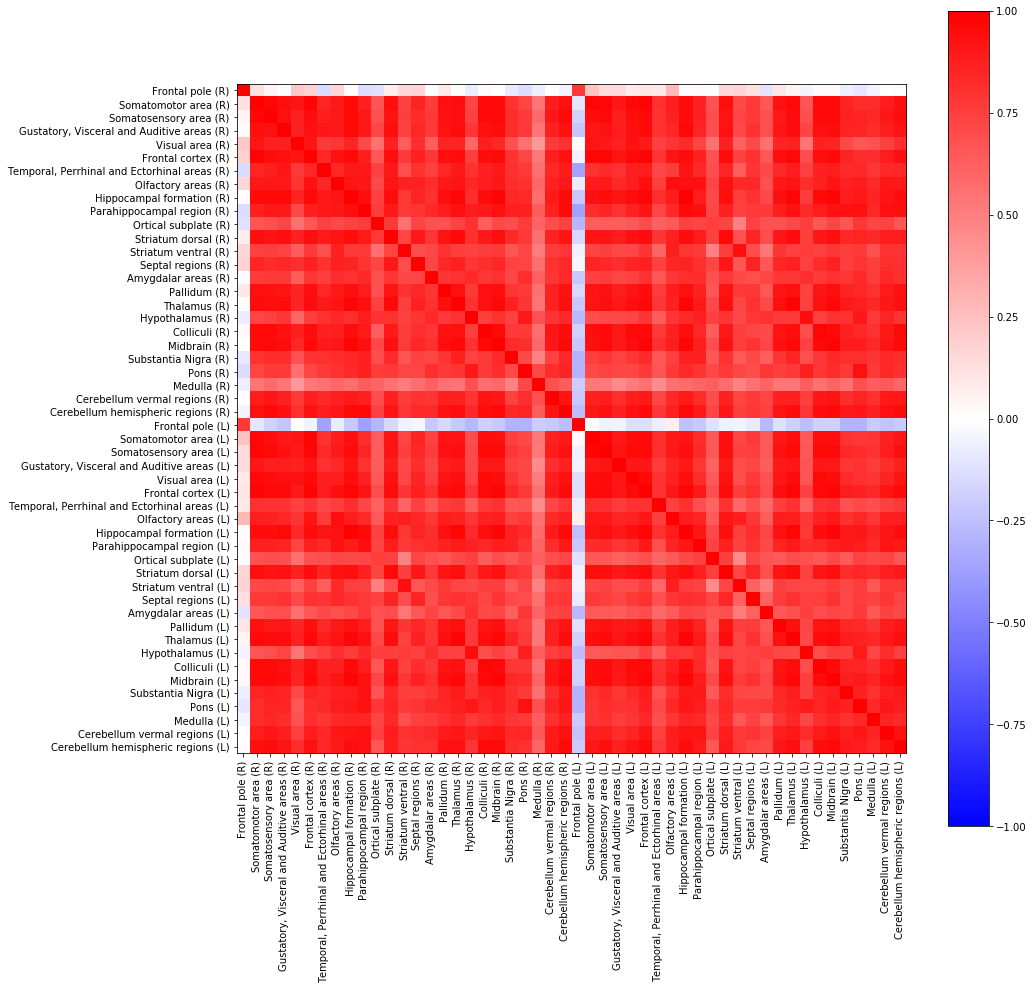

Saving matrix...
Done!!!
Connectivity matrix of subject F572 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F573_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

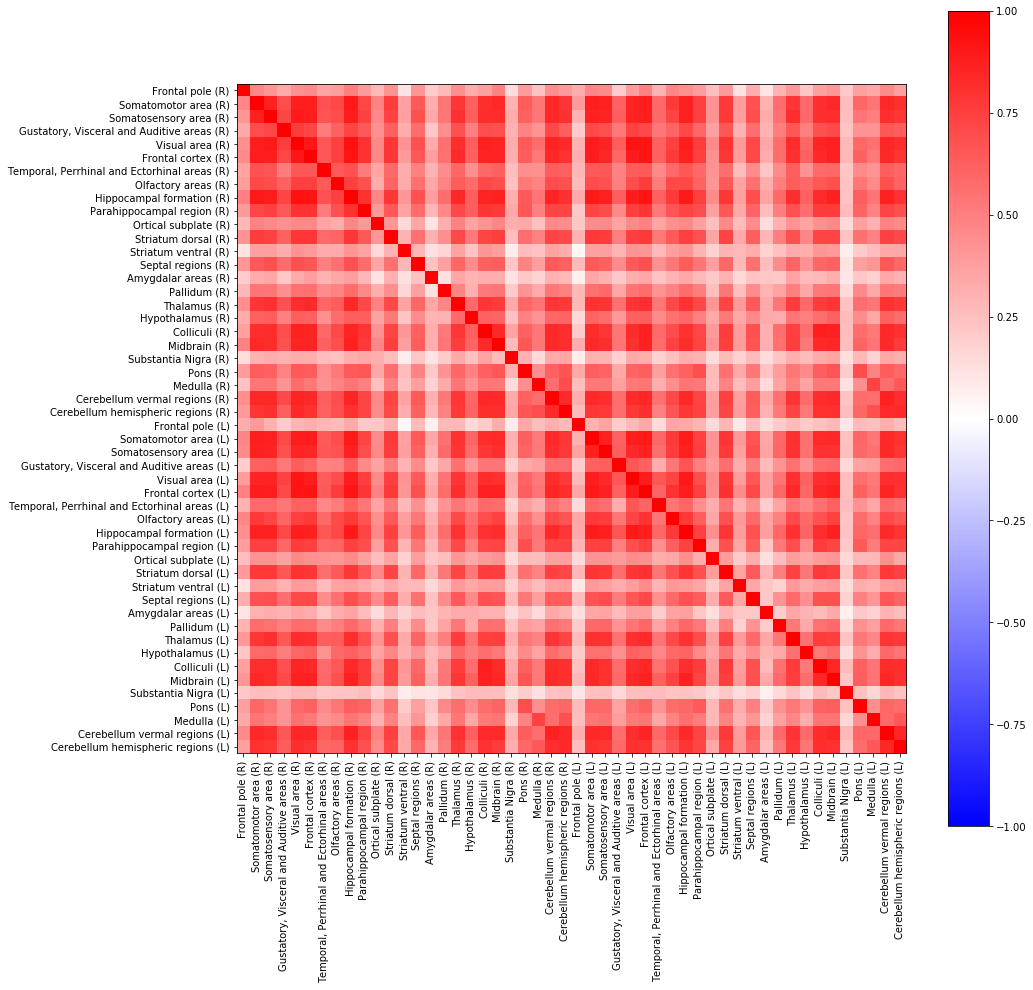

Saving matrix...
Done!!!
Connectivity matrix of subject F573 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F574_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

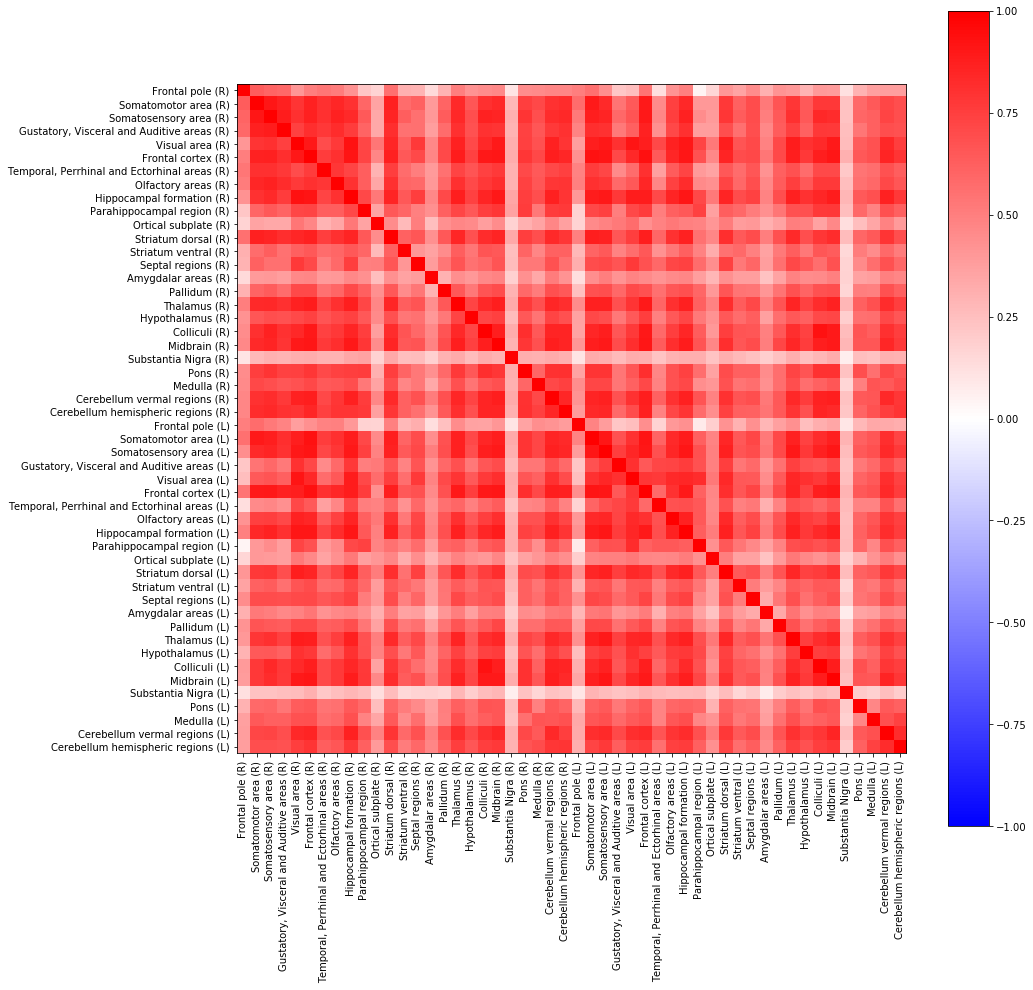

Saving matrix...
Done!!!
Connectivity matrix of subject F574 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F582_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

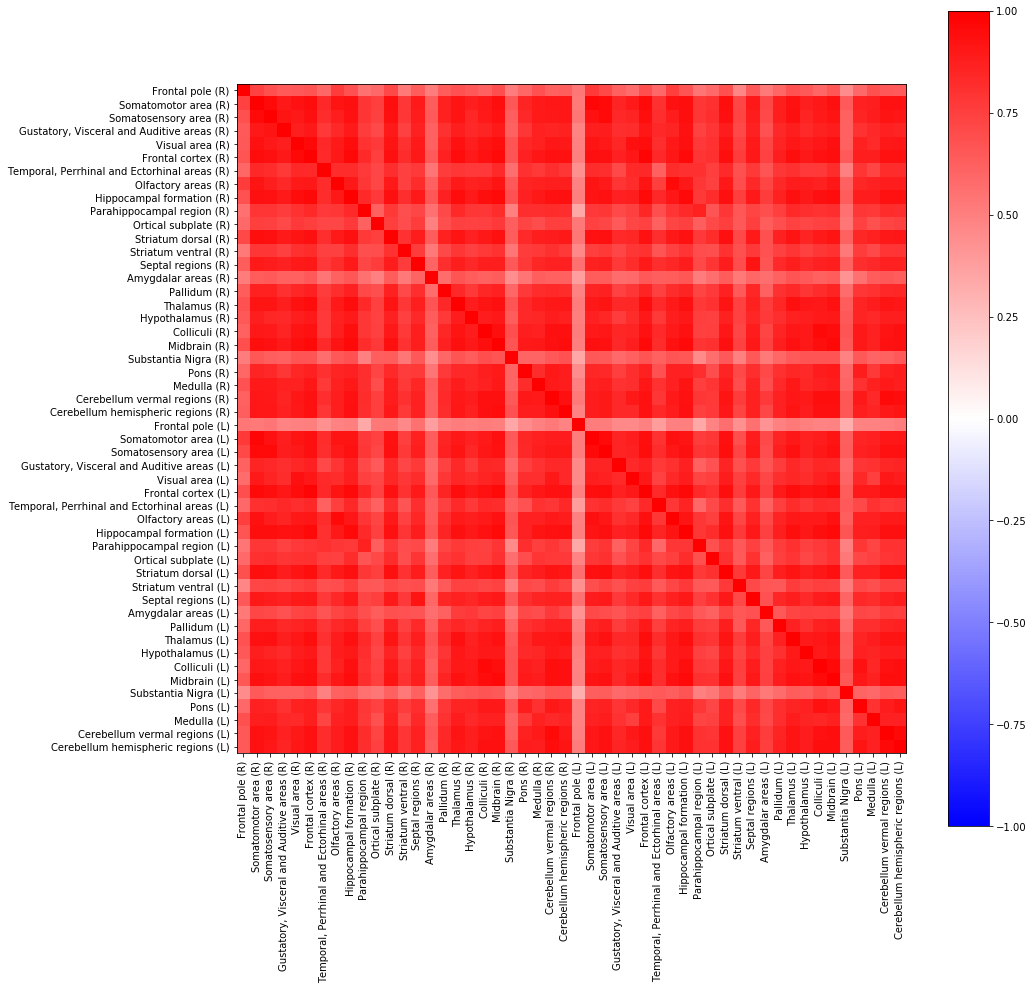

Saving matrix...
Done!!!
Connectivity matrix of subject F582 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F583_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

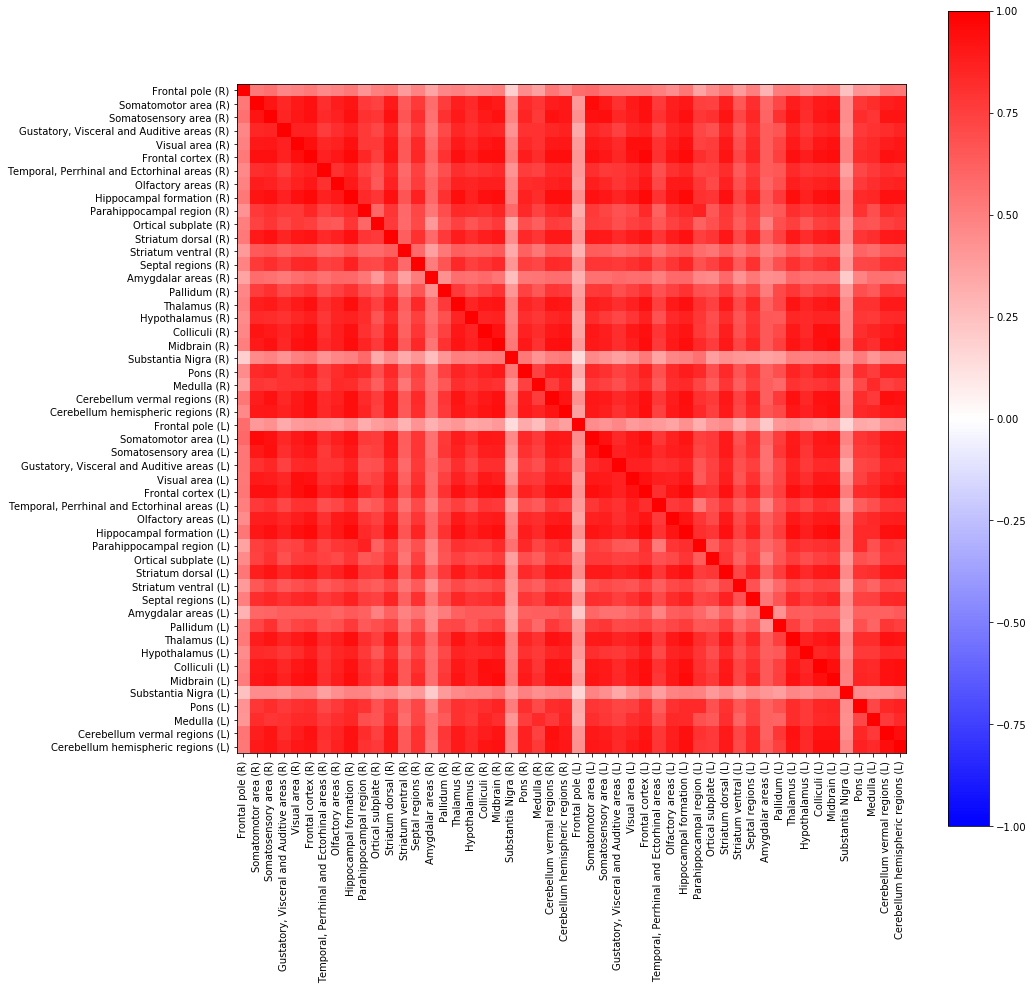

Saving matrix...
Done!!!
Connectivity matrix of subject F583 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F584_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

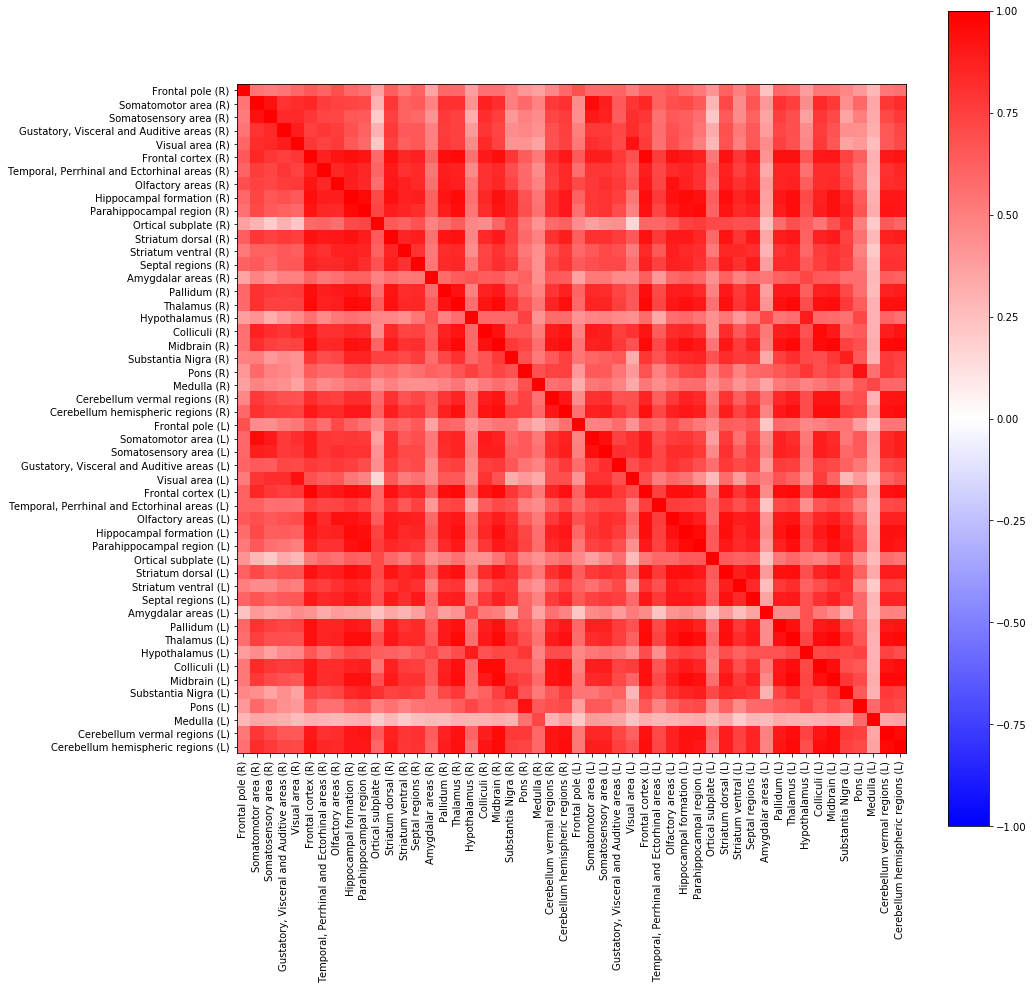

Saving matrix...
Done!!!
Connectivity matrix of subject F584 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F585_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

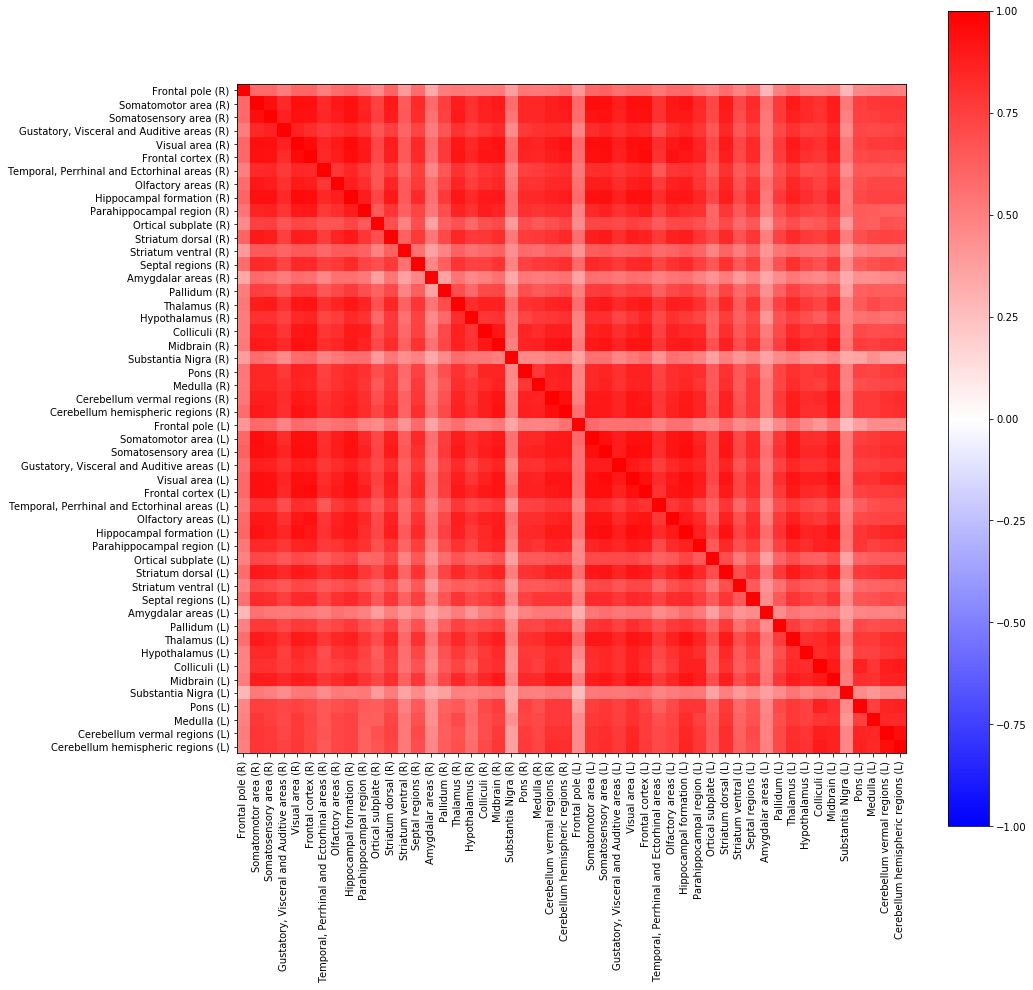

Saving matrix...
Done!!!
Connectivity matrix of subject F585 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F596_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

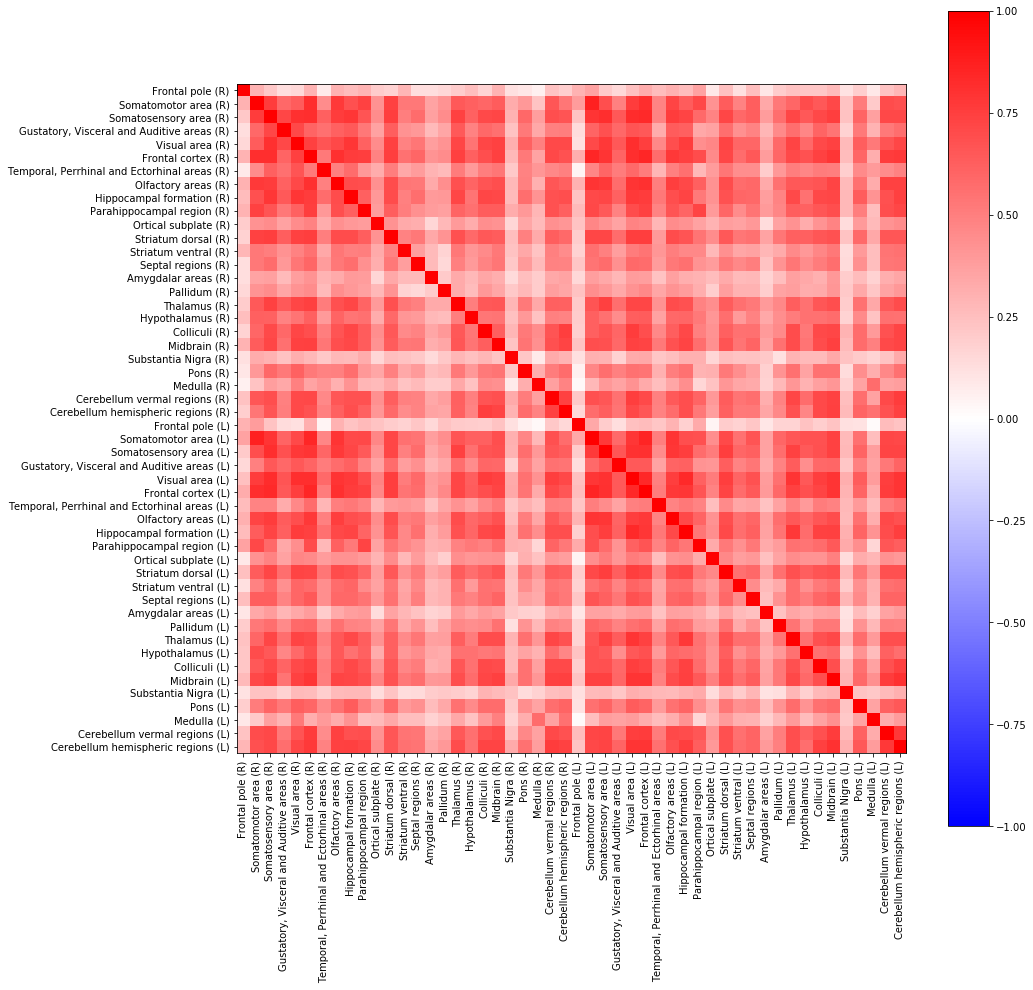

Saving matrix...
Done!!!
Connectivity matrix of subject F596 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F597_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

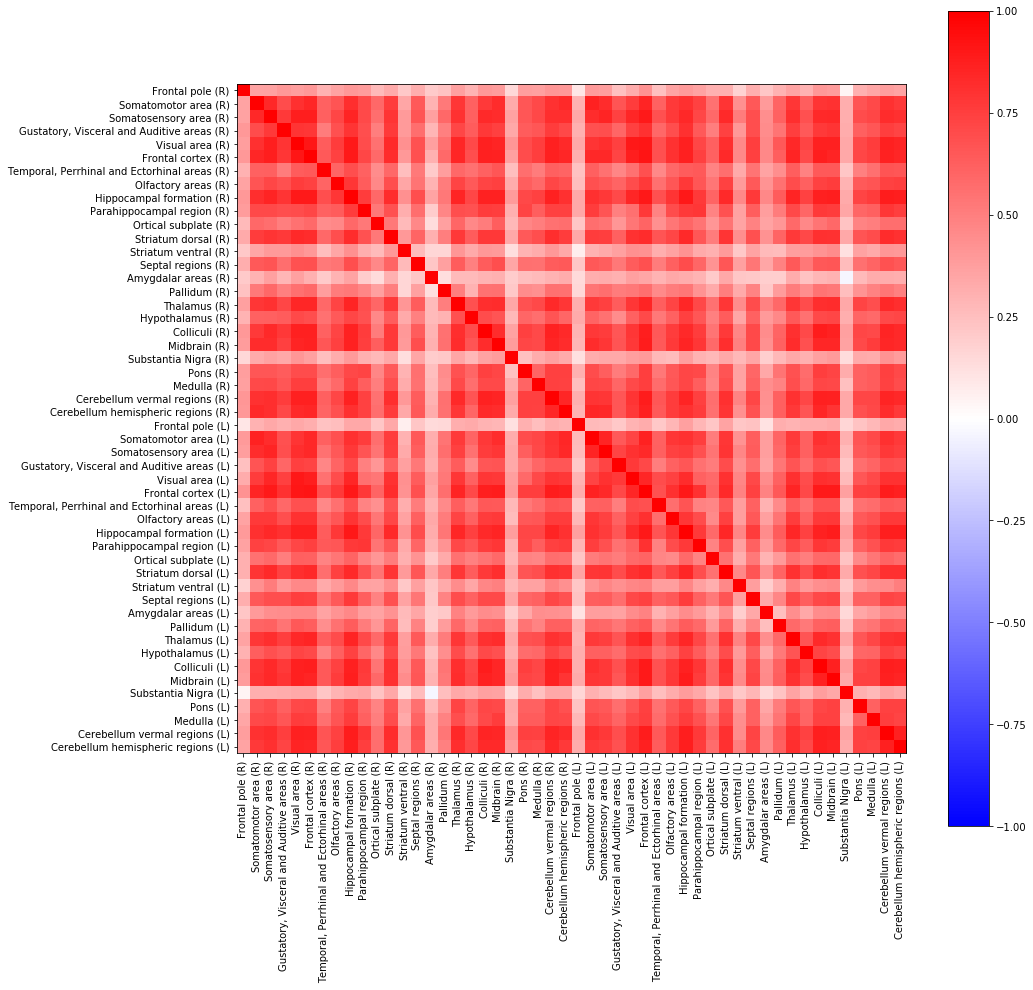

Saving matrix...
Done!!!
Connectivity matrix of subject F597 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F601_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

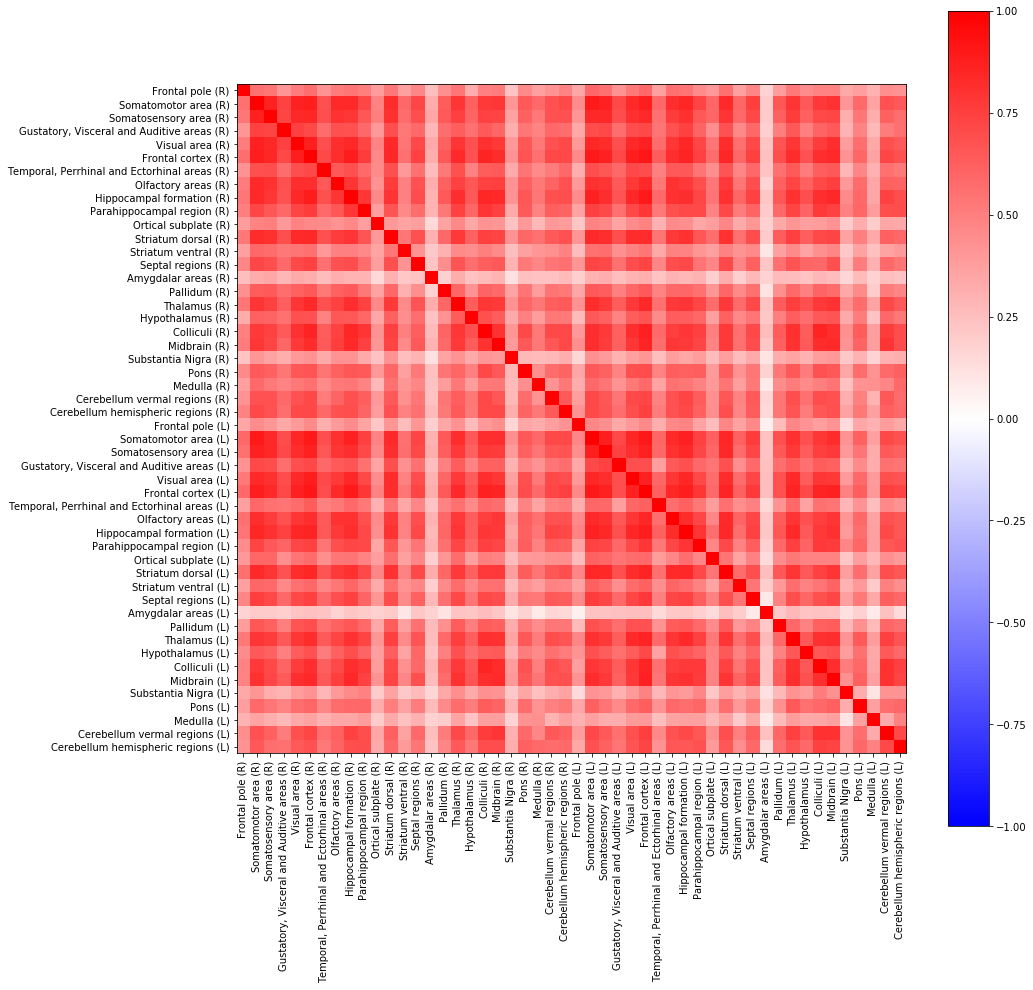

Saving matrix...
Done!!!
Connectivity matrix of subject F601 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F602_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

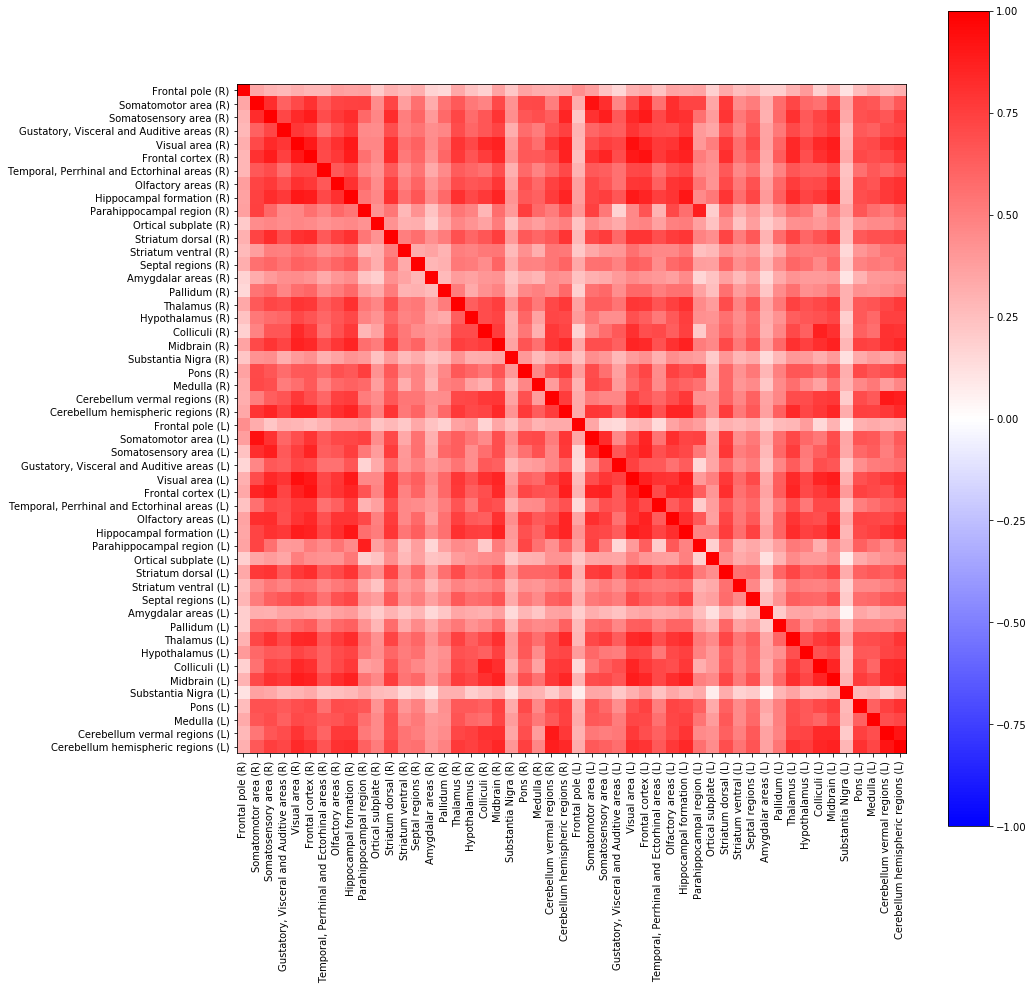

Saving matrix...
Done!!!
Connectivity matrix of subject F602 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F603_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

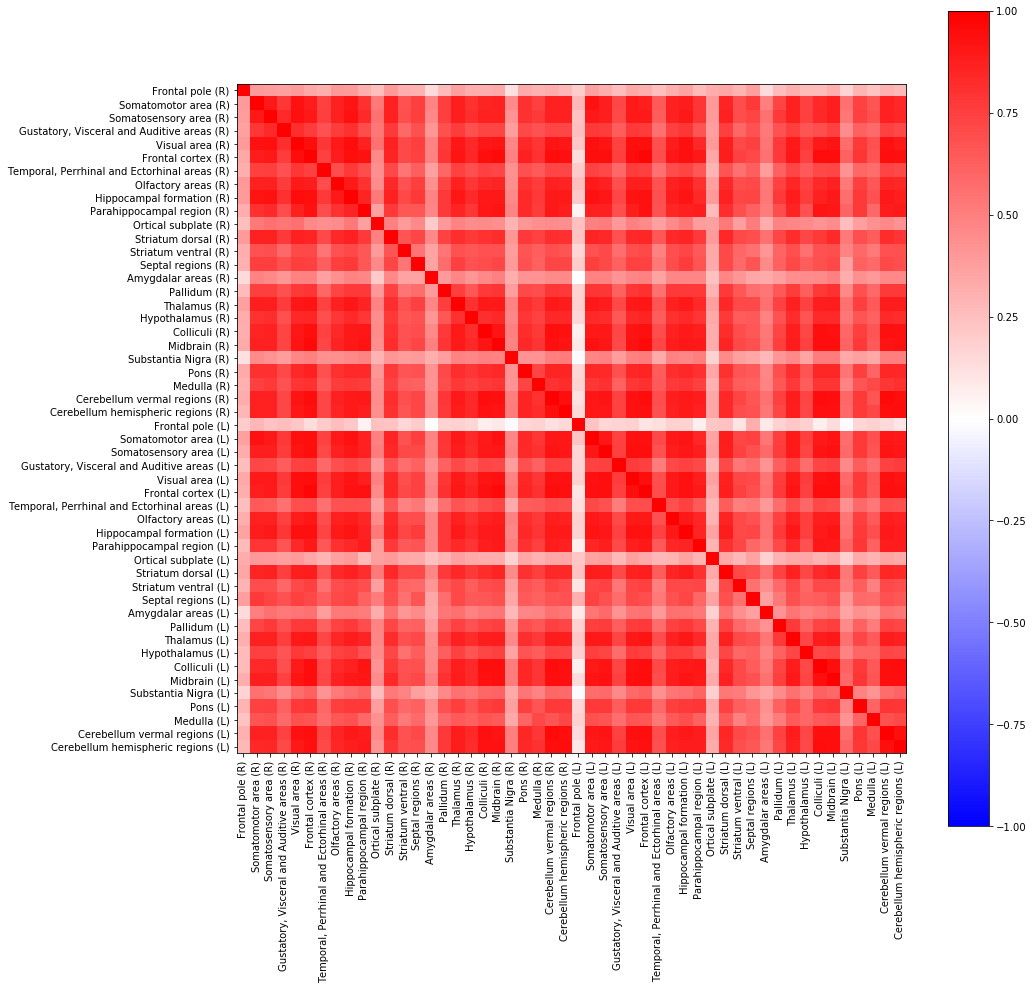

Saving matrix...
Done!!!
Connectivity matrix of subject F603 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_F604_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Saving image...
Done!!!


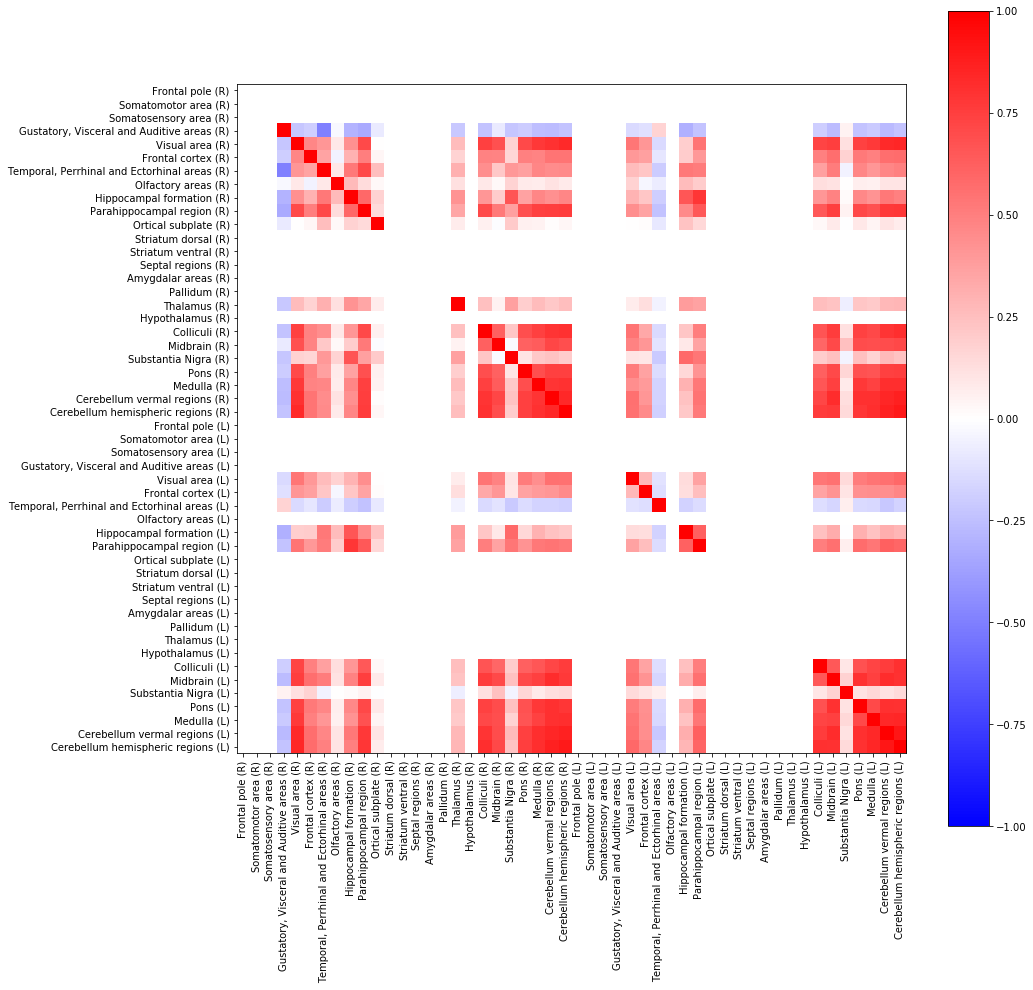

Saving matrix...
Done!!!
Connectivity matrix of subject F604 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M570_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

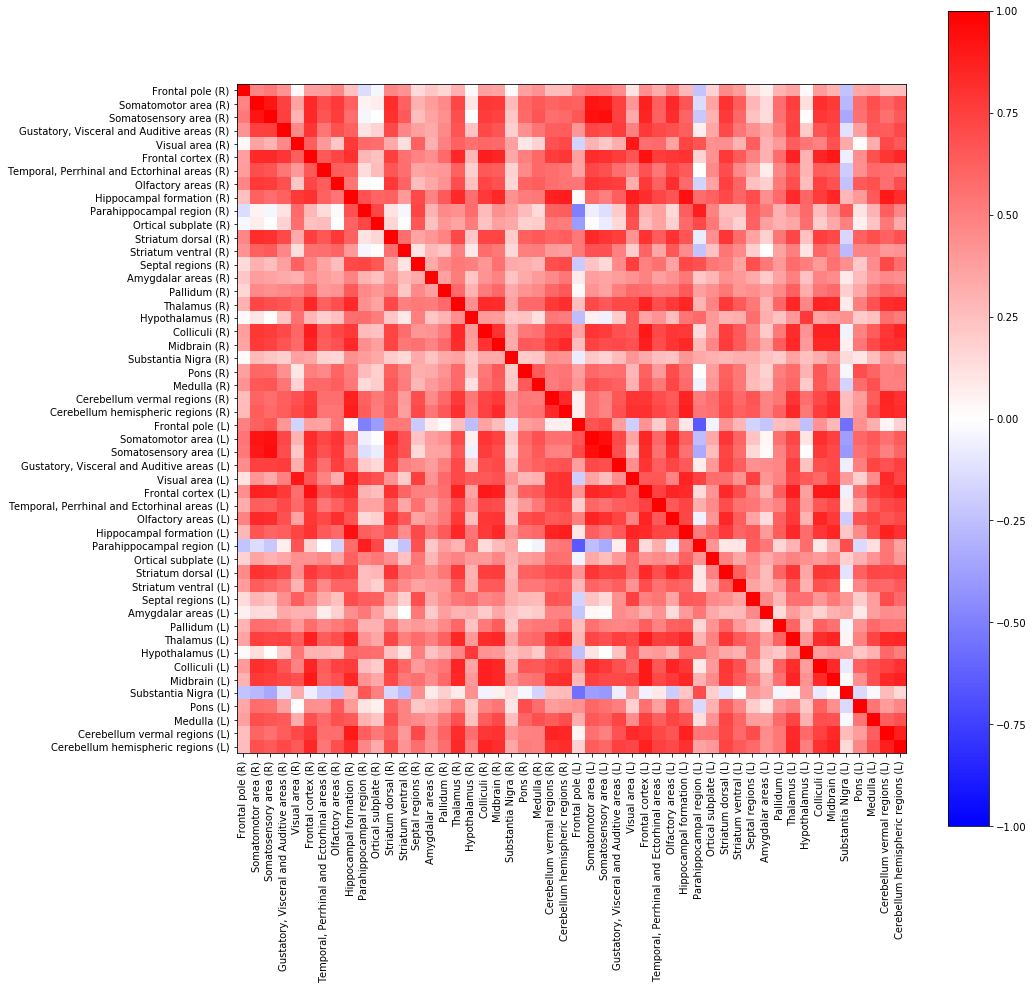

Saving matrix...
Done!!!
Connectivity matrix of subject M570 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M571_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

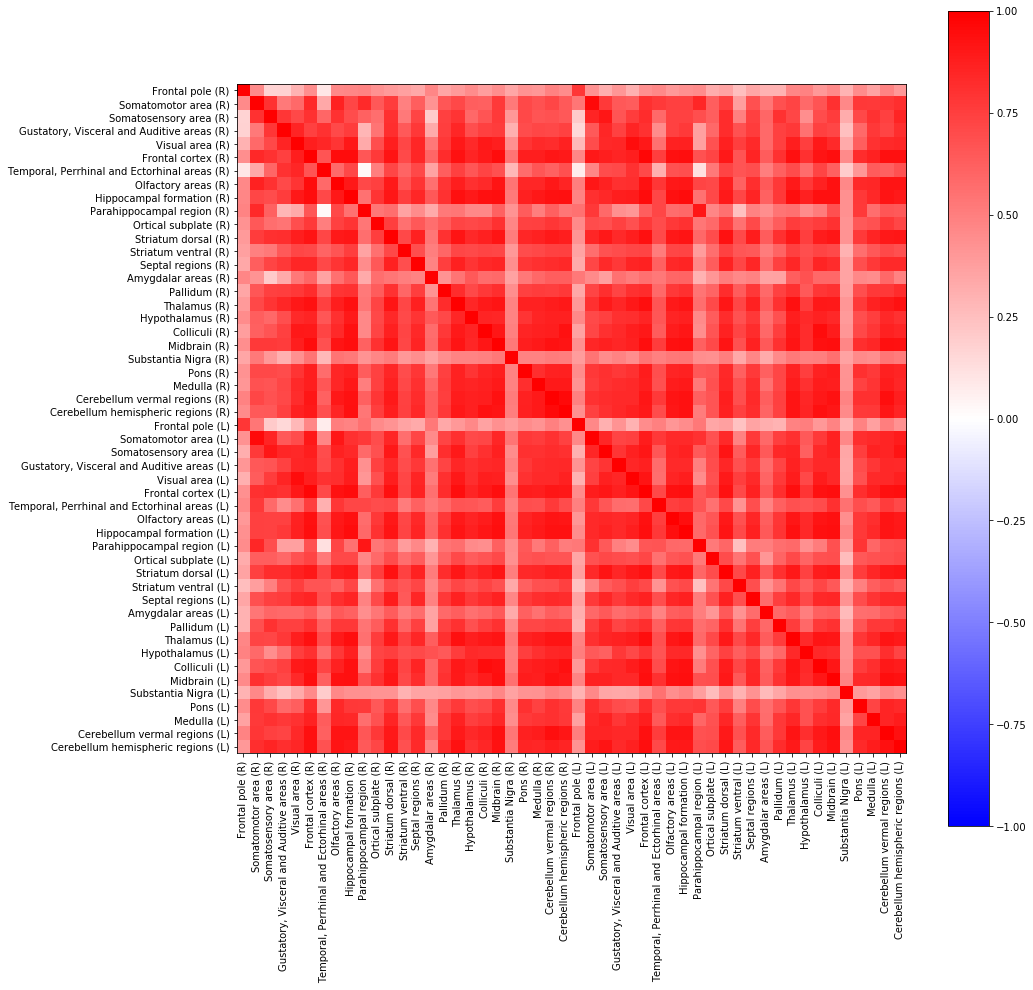

Saving matrix...
Done!!!
Connectivity matrix of subject M571 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M575_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Done!!!


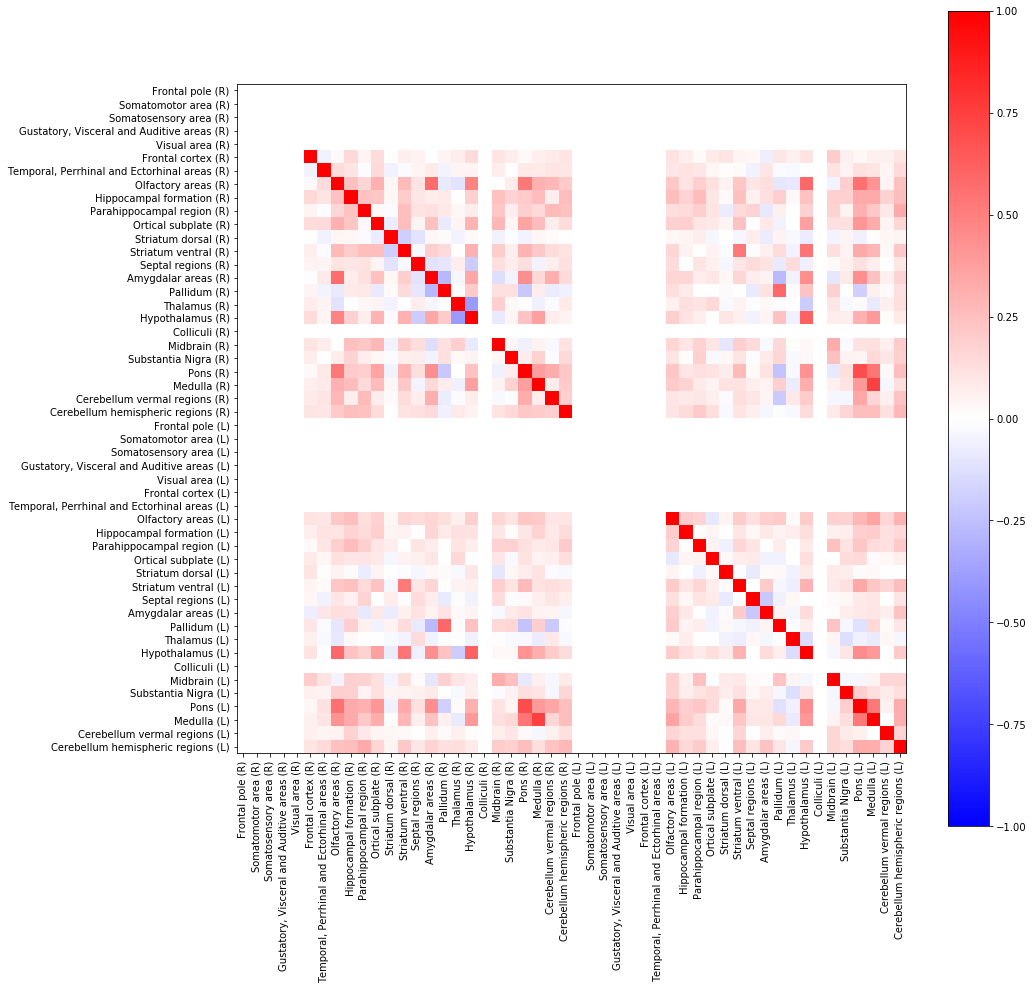

Saving matrix...
Done!!!
Connectivity matrix of subject M575 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M577_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

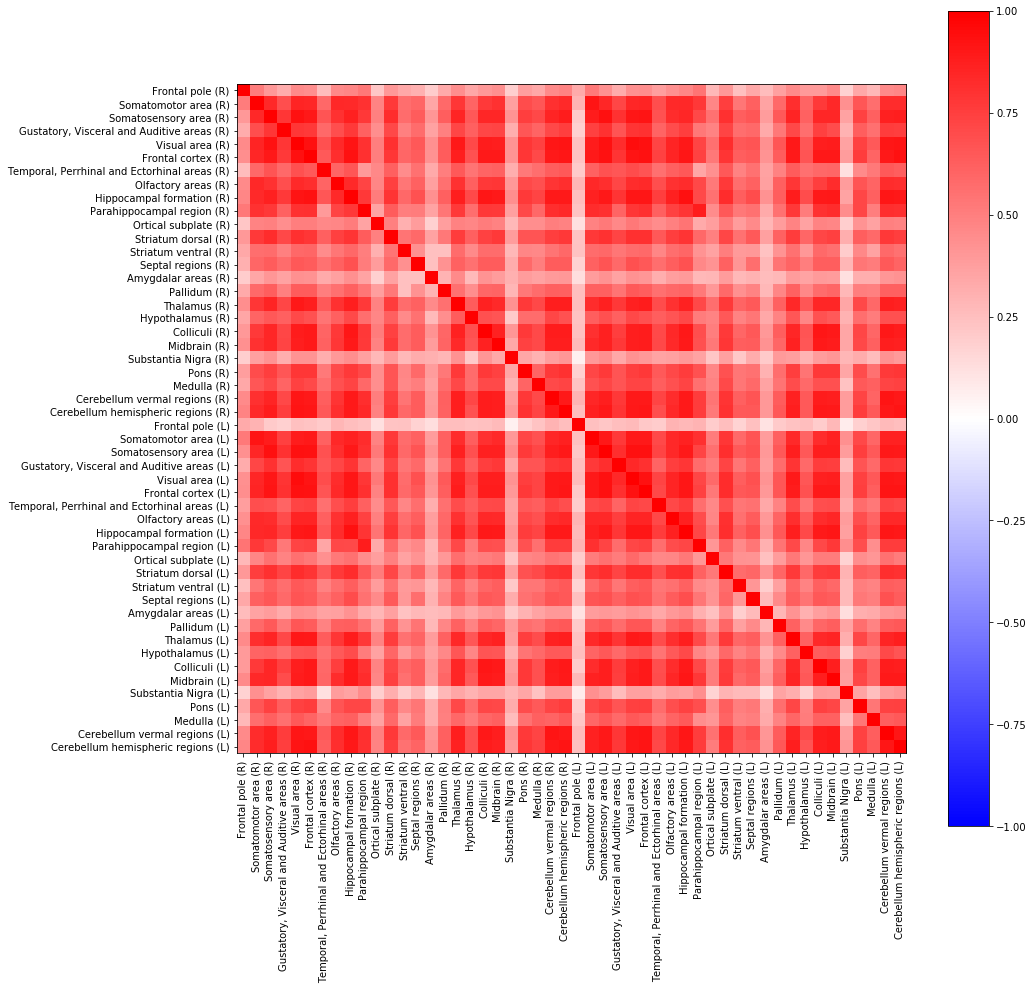

Saving matrix...
Done!!!
Connectivity matrix of subject M577 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M578_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

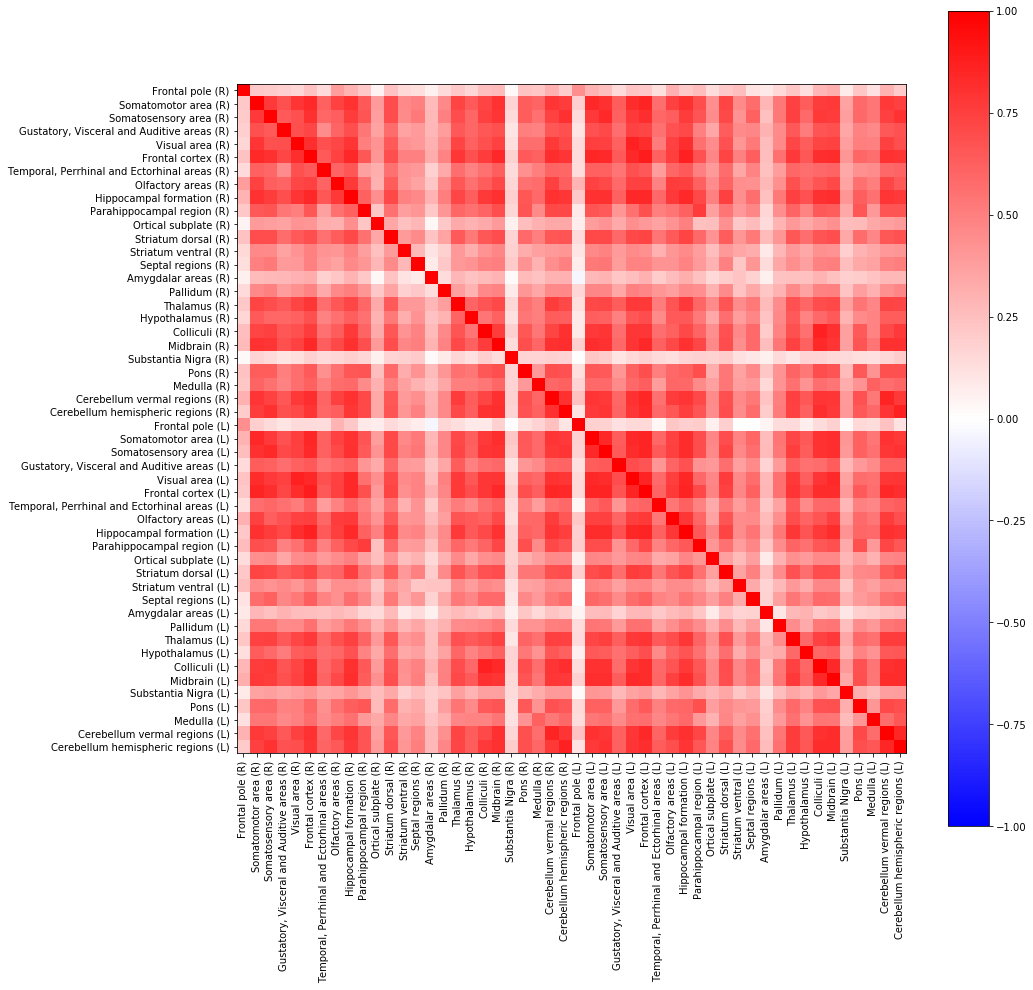

Saving matrix...
Done!!!
Connectivity matrix of subject M578 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M579_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

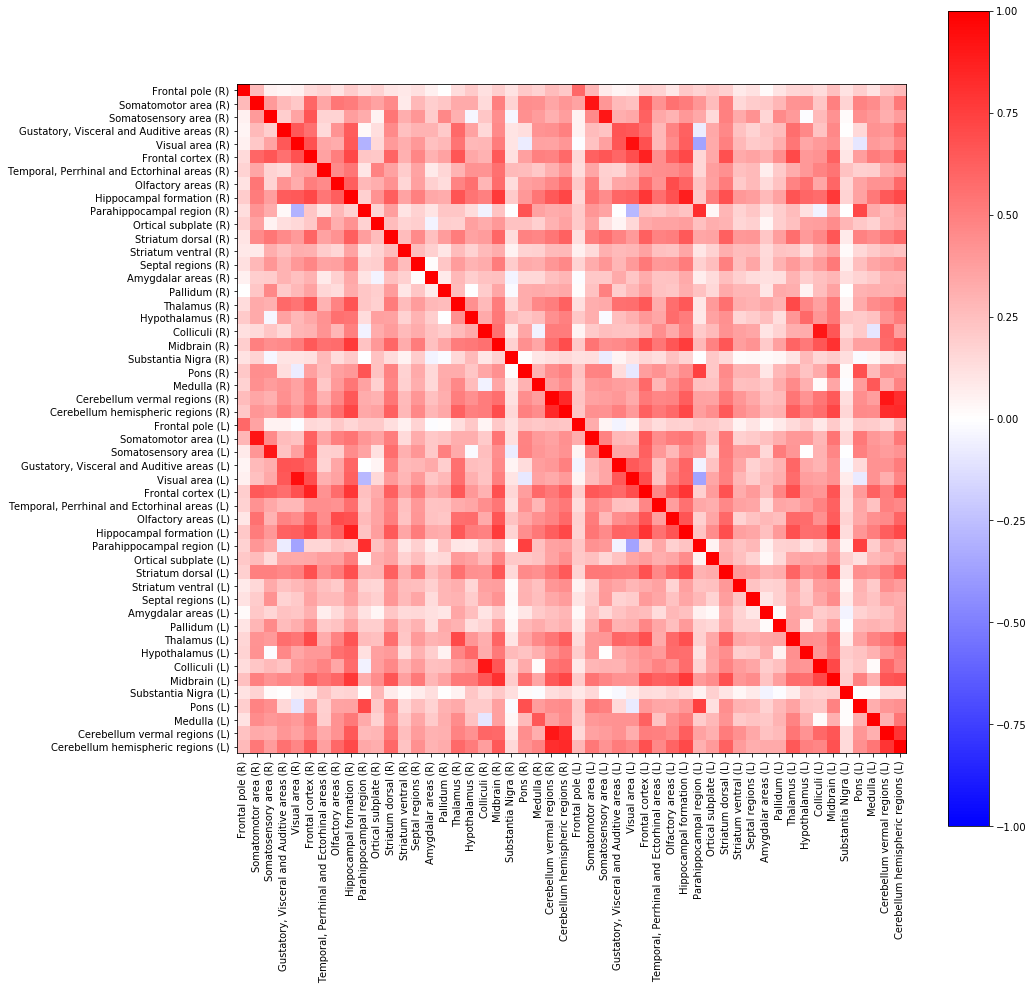

Saving matrix...
Done!!!
Connectivity matrix of subject M579 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M580_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

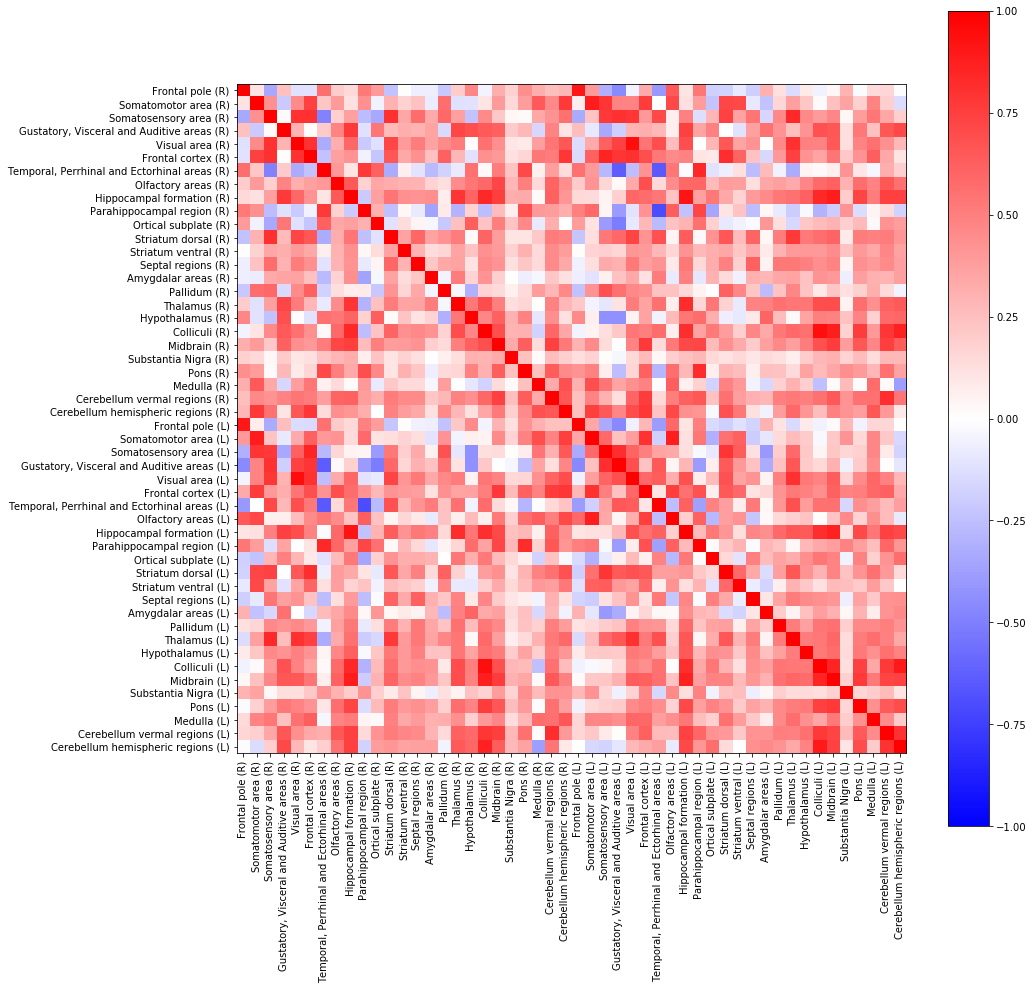

Saving matrix...
Done!!!
Connectivity matrix of subject M580 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M587_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

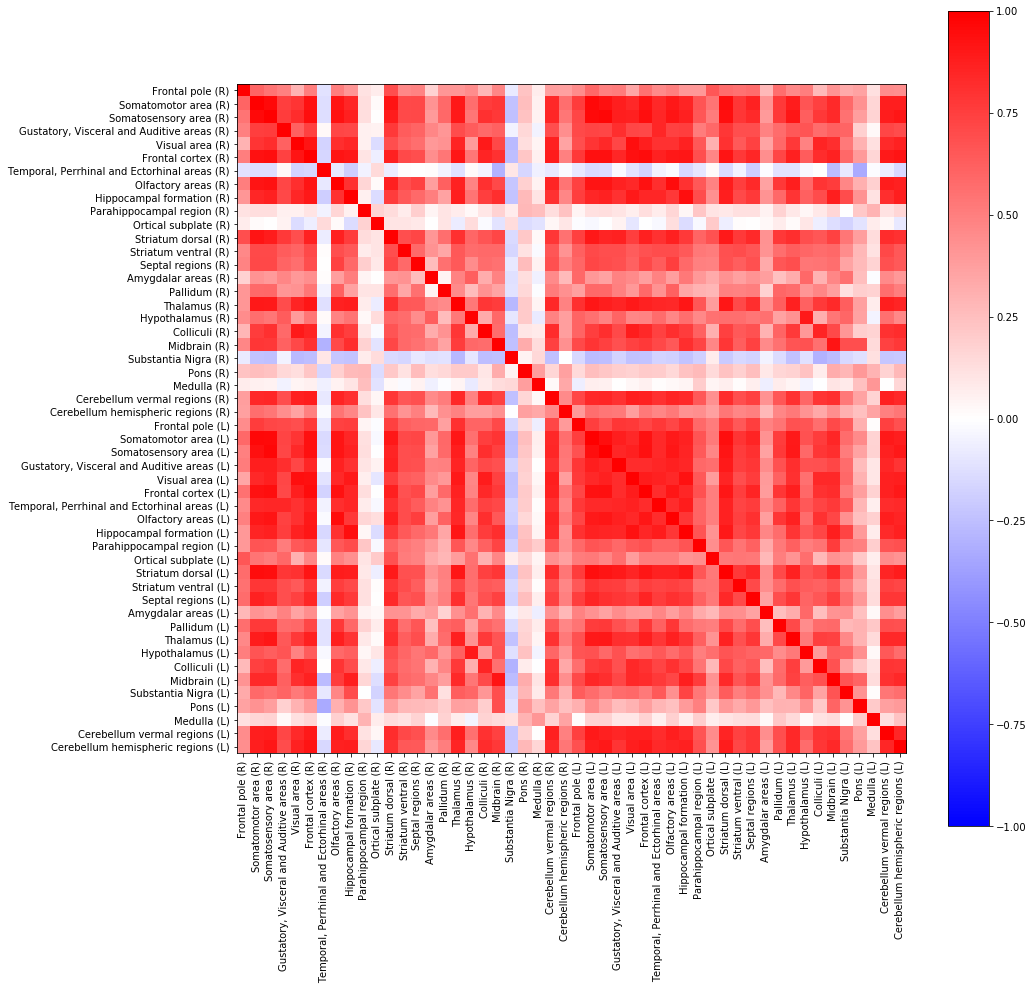

Saving matrix...
Done!!!
Connectivity matrix of subject M587 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M588_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

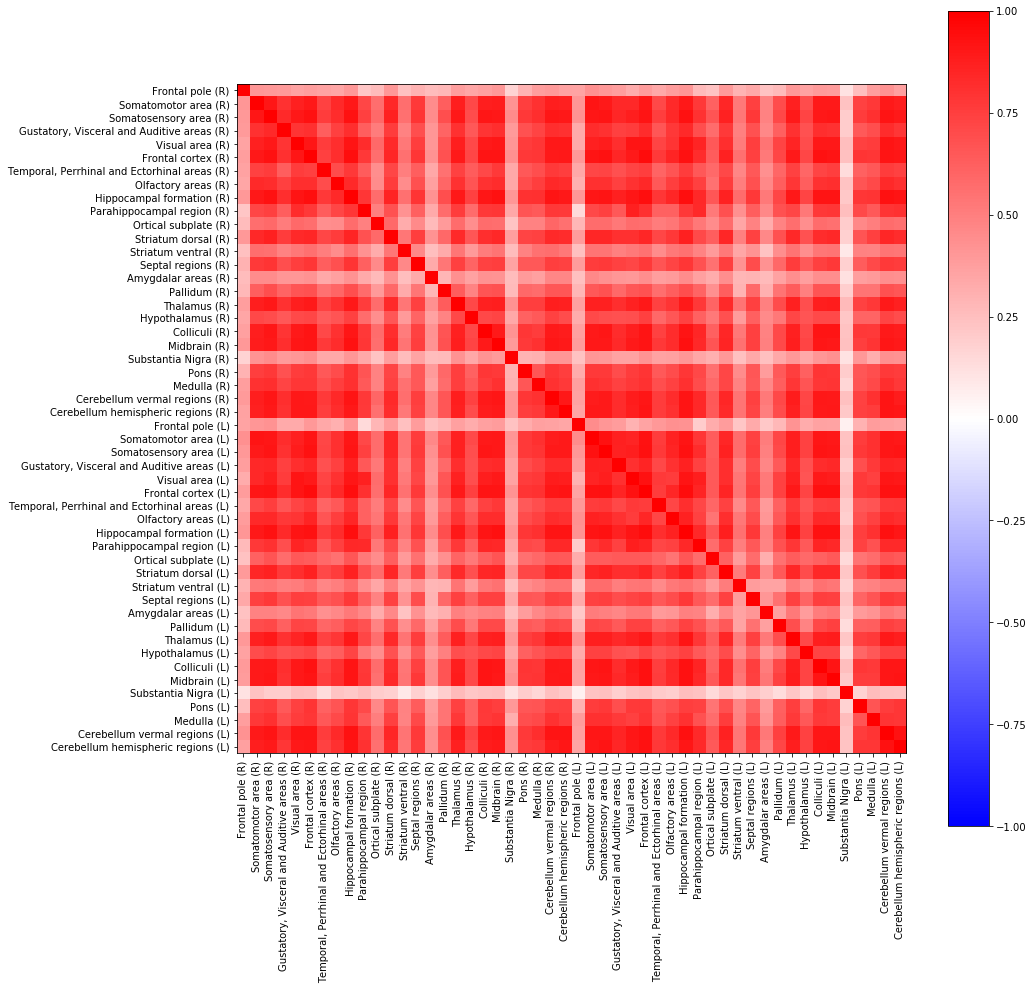

Saving matrix...
Done!!!
Connectivity matrix of subject M588 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M589_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Done!!!


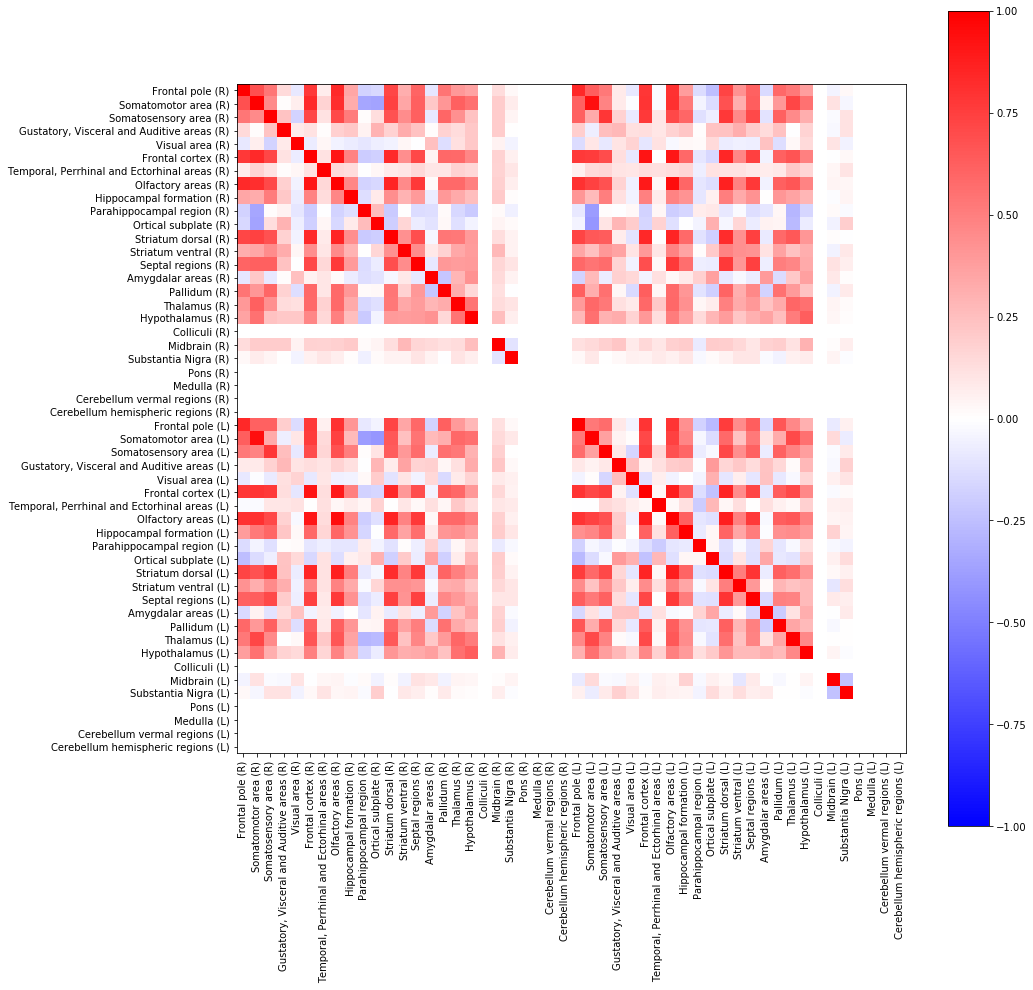

Saving matrix...
Done!!!
Connectivity matrix of subject M589 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M590_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

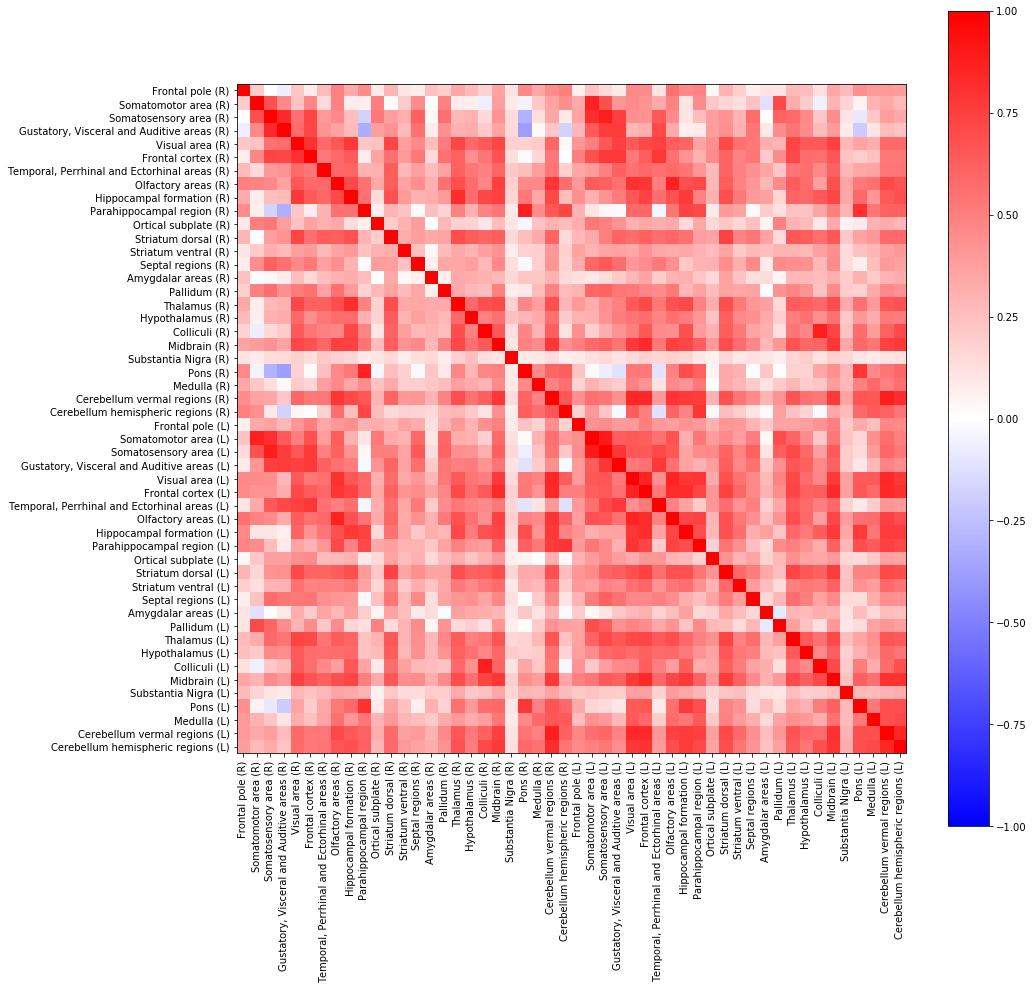

Saving matrix...
Done!!!
Connectivity matrix of subject M590 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M593_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Done!!!


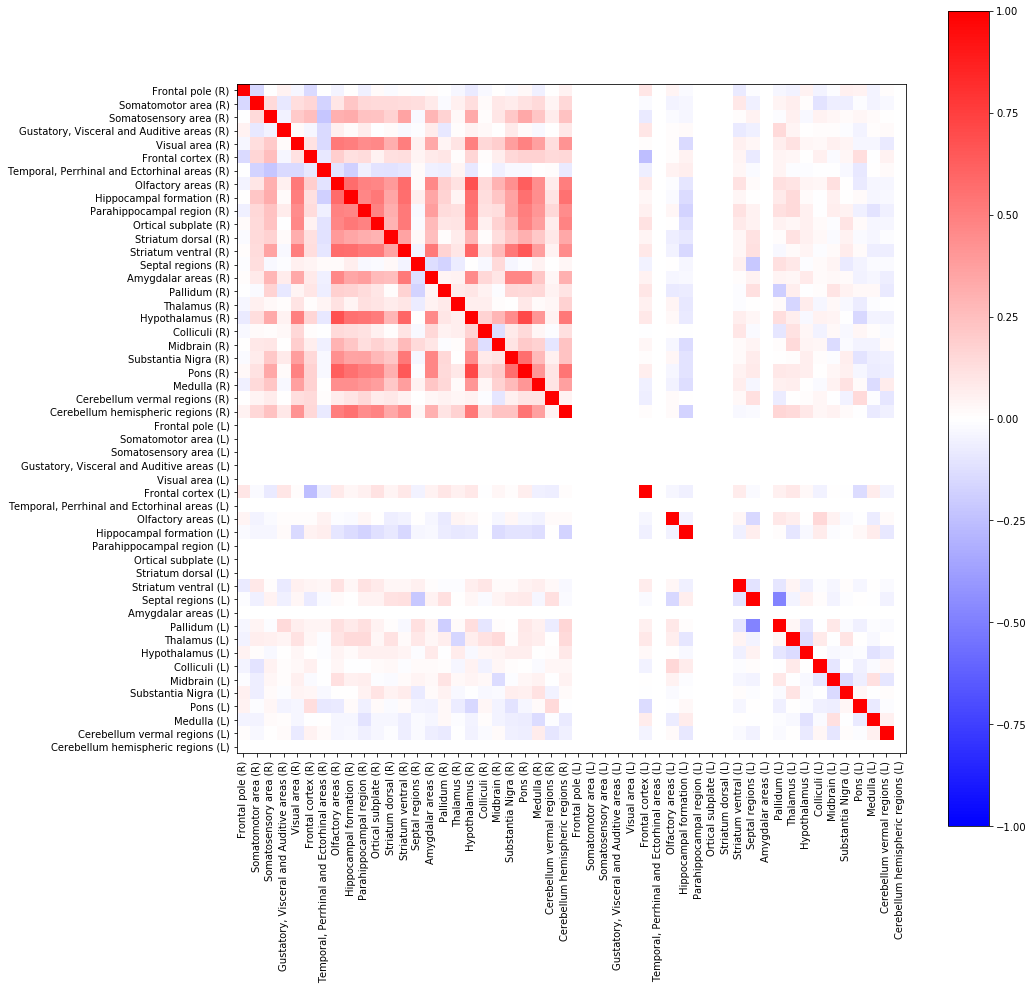

Saving matrix...
Done!!!
Connectivity matrix of subject M593 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M606_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Saving image...
Done!!!


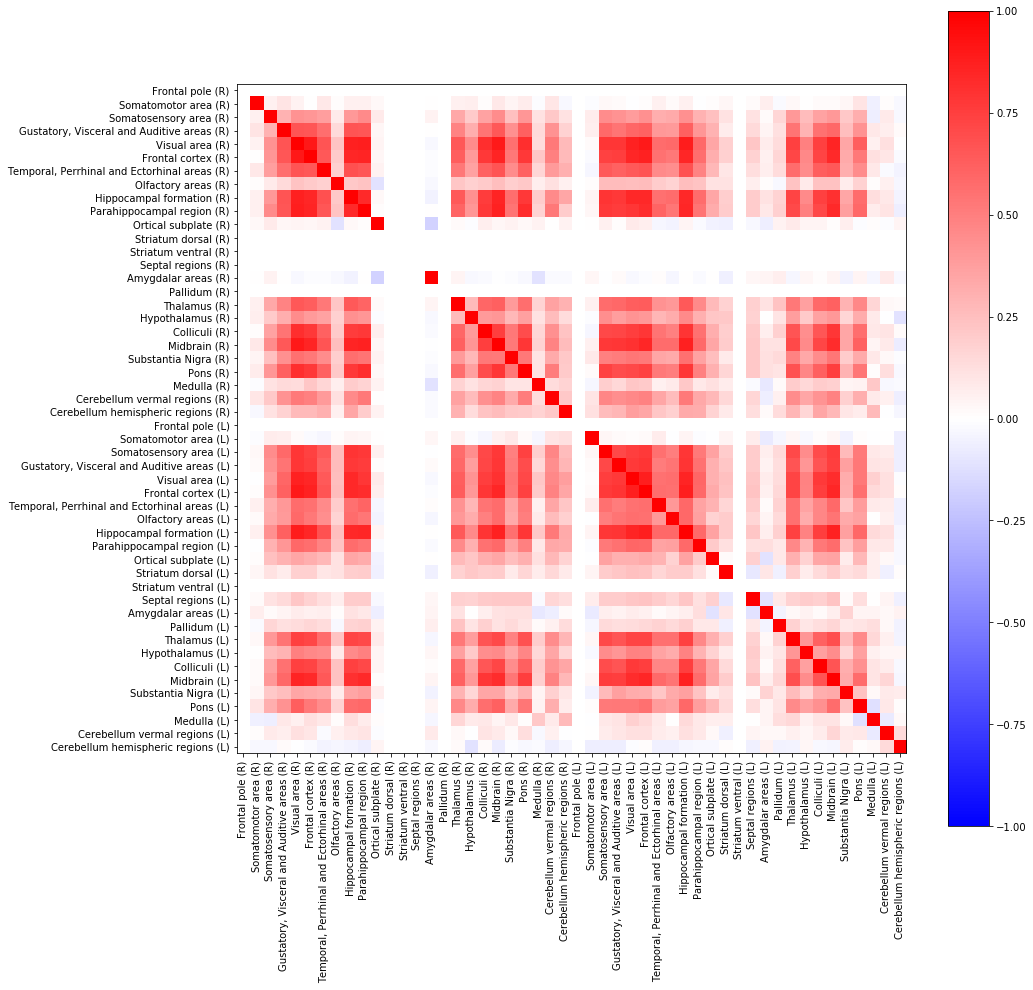

Saving matrix...
Done!!!
Connectivity matrix of subject M606 made!!!
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices/20230620_024619_secondAcquisition-groupedProcessing_allSubjects_nLabels-25_butterworthFilter_lowCut-0.01_highCut-0.1_fs-1.0_filterOrder-5_invProblParam-1.0e-04_weightNormOption-1_eraseFirstLabelOption-1/connectivityMatrix_M607_25Labels

Original labels:
        0                                           1
0       0                                        root
1       7                            Frontal pole (R)
2      19                        Somatomotor area (R)
3      45                      Somatosensory area (R)
4     108  Gustatory, Visceral and Auditive areas (R)
..    ...                                         ...
224  3299                         Third ventricle (L)
225  3300                       Cerebral aqueduct (L)
226  3301                        Fourth ventricle (L)
227  3302                          Lateral rec

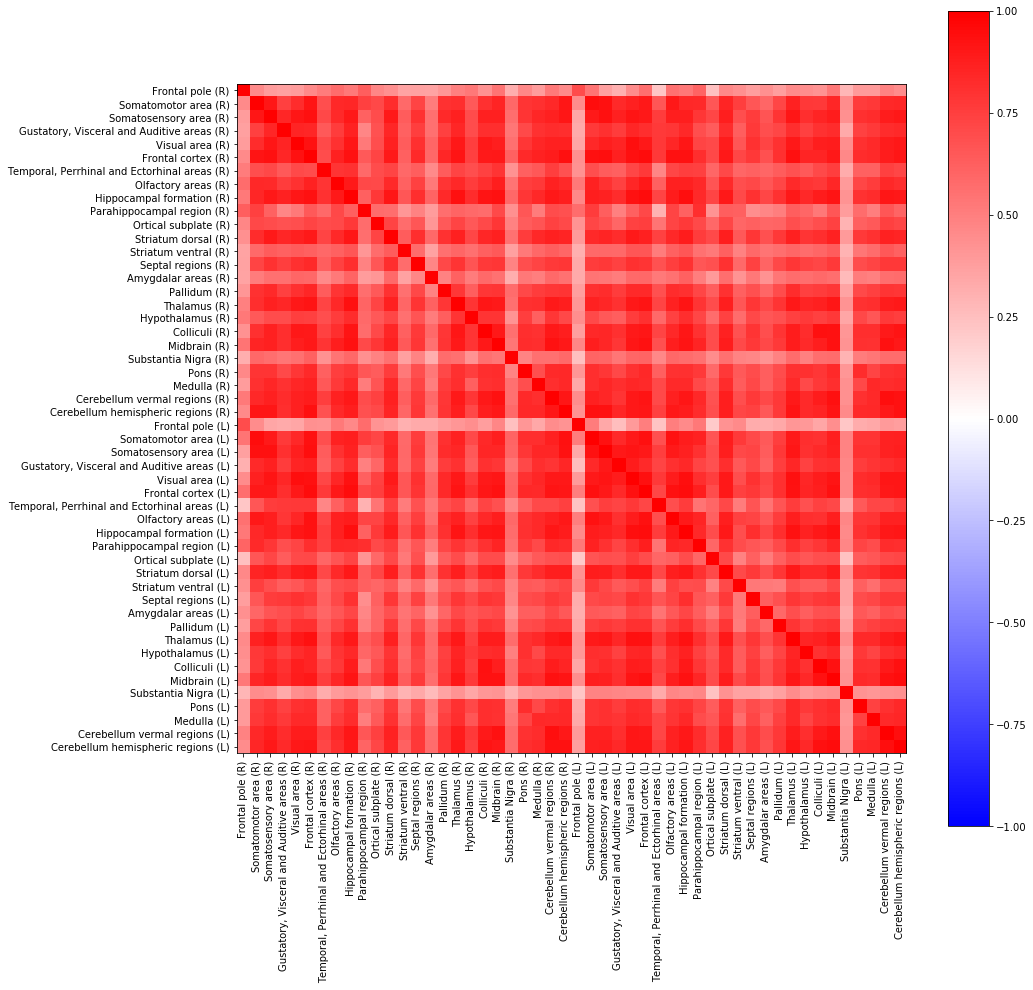

Saving matrix...
Done!!!
Connectivity matrix of subject M607 made!!!


In [10]:
# ******************************************************************************************************************
# Create connectivity matrices
# ******************************************************************************************************************

# ==================================================================================================================
# Reduced correlation matrix (only gray matter)
# ==================================================================================================================
outputDir = '/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/conectivityMatrices'
pathLabels = '/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/atlasesTemplates/p56_original_smallRegionsGrouped/p56_smallRegionsGrouped_idAndLabels_v5_leftRight.txt'

TR=1
#lowFreqCutArray = [0.0625]
#highFreqCutArray = [0.125]
lowFreqCutArray = [0.01]
highFreqCutArray = [0.1]
#frequencyFilterOrderArray = [1,2,3,4,5,6,7]
#invProblemParamArray = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0,1e+1,1e+2,1e+3,1e+4,1e+5,1e+6]
frequencyFilterOrderArray = [5]
invProblemParamArray = [1e-4]
samplFreq = 1/TR
abundNormalizFlag = 1
numLabels = '25' #25; all
eraseFirstLabelFlag = 1
extSaveImage = '.png'
extSaveMatrix = '.mat'
printResultsFlag = 1
figureSize = 15 #15 for numLabels = '25'; 50 for numLabels = 'all'
saveFilesFlag = 1
saveArraysFlag = 0
folderNameStr = 'secondAcquisition-groupedProcessing_allSubjects'


#Create and show connectivity matrices XXX
CreateConnectivityMatrix(pathInputBoldImageOrg, arrayPath_brainMask4InputBold, arrayAtlasResampledPath_tmpl2CommInvWarpAffine_anat2TemplateInverseWarp_bold2AnatInverseWarp_correctedBold2InputBold, pathLabels, arraySubjects, outputDir, lowFreqCutArray, highFreqCutArray, samplFreq, frequencyFilterOrderArray, invProblemParamArray, abundNormalizFlag, numLabels,  eraseFirstLabelFlag, extSaveImage, extSaveMatrix, folderNameStr, printResultsFlag, figureSize, saveFilesFlag, saveArraysFlag)

# ==================================================================================================================
# ==================================================================================================================
# ==================================================================================================================

# ******************************************************************************************************************
# ******************************************************************************************************************
# ******************************************************************************************************************

In [29]:
# ******************************************************************************************************************
# Miscellaneous analysis
# ******************************************************************************************************************

subIdx = 0
print(pathCorrectedBoldImageOrg[subIdx]) 
print(pathCorrectedBoldBrainMaskImageOrg[subIdx]) 
print(pathRegisteredAtlasImageOrg[subIdx])

/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/rabiesPreProcessing/20230310_output_secondAcquisition_groupedProcessing/bold_datasink/corrected_bold/_scan_info_subject_idF572.session1_split_name_MAP6_rs-fMRI_mouse-2022_11_29_MAP6_rs-fMRI_mouse_F572-2022-11-29081351-08-T2_TurboRARE-BrukerRARE-001546_987_mrLinTrans_fslSwapDim-RAS_T2w/_run_None/MAP6_rs-fMRI_mouse-2022_11_29_MAP6_rs-fMRI_mouse_F572-2022-11-29081351-09-GE_EPI-BrukerEPI-003000_000_mrLinTrans_fslSwapDim-RAS_bold_combined.nii.gz
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/rabiesPreProcessing/20230310_output_secondAcquisition_groupedProcessing/bold_datasink/bold_brain_mask/_scan_info_subject_idF572.session1_split_name_MAP6_rs-fMRI_mouse-2022_11_29_MAP6_rs-fMRI_mouse_F572-2022-11-29081351-08-T2_TurboRARE-BrukerRARE-001546_987_mrLinTrans_fslSwapDim-RAS_T2w/_run_None/MAP6_rs-fMRI_mouse-2022_11_29_MAP6_rs-fMRI_mouse_F572-2022-11-29081351-09-GE_EPI-BrukerEPI-003000_000_mrLinTrans_fsl

In [18]:
pathFramewiseDisplacement = pathMainInputDir + '/confounds_datasink/FD_csv'

pathFramewiseDisplacementCSV = BuildImagePath(pathFramewiseDisplacement,0,'/_run_None',0)
#PrintArray(pathFramewiseDisplacementCSV)
pathFramewiseDisplacementCSVOrg = SortArrayByRefArray(pathFramewiseDisplacementCSV, arraySubjects, 0)
PrintArray(pathFramewiseDisplacementCSVOrg)


Creating array of image paths...
Array size: 27 items.
Array with paths made!!!



Printing array...
Array length: 27
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/rabiesPreProcessing/20230310_output_secondAcquisition_groupedProcessing/confounds_datasink/FD_csv/_scan_info_subject_idF572.session1_split_name_MAP6_rs-fMRI_mouse-2022_11_29_MAP6_rs-fMRI_mouse_F572-2022-11-29081351-08-T2_TurboRARE-BrukerRARE-001546_987_mrLinTrans_fslSwapDim-RAS_T2w/_run_None/MAP6_rs-fMRI_mouse-2022_11_29_MAP6_rs-fMRI_mouse_F572-2022-11-29081351-09-GE_EPI-BrukerEPI-003000_000_mrLinTrans_fslSwapDim-RAS_bold_combined_FD_file.csv
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/rabiesPreProcessing/20230310_output_secondAcquisition_groupedProcessing/confounds_datasink/FD_csv/_scan_info_subject_idF573.session1_split_name_MAP6_rs-fMRI_mouse-2022_11_29_MAP6_rs-fMRI_mouse_F573-2022-11-29102918-08-T2_TurboRARE-BrukerRARE-001546_987_mrLinTrans_fslSwapDim-RAS_T2w/_run_None

In [20]:
pathTransRot =  pathMainInputDir + '/confounds_datasink/confounds_csv'

pathTransRotCSV = BuildImagePath(pathTransRot,0,'/_run_None',0)
#PrintArray(pathFramewiseDisplacementCSV)
pathTransRotCSVOrg = SortArrayByRefArray(pathTransRotCSV, arraySubjects, 0)
PrintArray(pathTransRotCSVOrg)


Creating array of image paths...
Array size: 27 items.
Array with paths made!!!



Printing array...
Array length: 27
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/rabiesPreProcessing/20230310_output_secondAcquisition_groupedProcessing/confounds_datasink/confounds_csv/_scan_info_subject_idF572.session1_split_name_MAP6_rs-fMRI_mouse-2022_11_29_MAP6_rs-fMRI_mouse_F572-2022-11-29081351-08-T2_TurboRARE-BrukerRARE-001546_987_mrLinTrans_fslSwapDim-RAS_T2w/_run_None/MAP6_rs-fMRI_mouse-2022_11_29_MAP6_rs-fMRI_mouse_F572-2022-11-29081351-09-GE_EPI-BrukerEPI-003000_000_mrLinTrans_fslSwapDim-RAS_bold_combined_confounds.csv
/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/rabiesPreProcessing/20230310_output_secondAcquisition_groupedProcessing/confounds_datasink/confounds_csv/_scan_info_subject_idF573.session1_split_name_MAP6_rs-fMRI_mouse-2022_11_29_MAP6_rs-fMRI_mouse_F573-2022-11-29102918-08-T2_TurboRARE-BrukerRARE-001546_987_mrLinTrans_fslSwapDim-R

In [38]:
#print(pathCorrectedBoldImageOrg)
#print(pathCorrectedBoldBrainMaskImageOrg)
print(pathRegisteredAtlasImageOrg)

#print(pathLabels)
#print(arraySubjects)

# ******************************************************************************************************************
# ******************************************************************************************************************
# ******************************************************************************************************************

['/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/p56_smallRegionsGrouped_v5_leftRight_4D_resampled_template2CommonInverseWarpAffine_anat2TemplateInverseWarpAffine_bold2AnatInverseWarpAffine_F572.nii', '/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/p56_smallRegionsGrouped_v5_leftRight_4D_resampled_template2CommonInverseWarpAffine_anat2TemplateInverseWarpAffine_bold2AnatInverseWarpAffine_F573.nii', '/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/p56_smallRegionsGrouped_v5_leftRight_4D_resampled_template2CommonInverseWarpAffine_anat2TemplateInverseWarpAffine_bold2AnatInverseWarpAffine_F574.nii', '/data_network/summer_projects/alvesrod/Share/2022_mouse-rsfMRI/outputs/atlas2EPI_inverseTransformationRabies/p56_smallRegionsGrouped_v5_leftRight_4D_resampled_template2CommonInverseWarpAffine_anat2TemplateInverse